In [38]:
import pandas as pd
import os
import numpy as np
import plotly.graph_objects as go
# import mitosheet
import plotly.express as px
import matplotlib.pyplot as plt
import pickle 
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter, ParetoNBDFitter, ModifiedBetaGeoFitter

In [36]:
# Specify the file path where you want to save the pickle file
file_path = 'segmentation_data.pkl'


# Open the file in binary write mode and save the data
with open(file_path, 'wb') as file:
    pickle.dump(clv_warzywa, file)

In [37]:
file_path = 'segmentation_data.pkl'

# Open the file in binary read mode and load the data
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

In [39]:
df = pd.read_csv("./dystrybucja_warzyw.csv")

# mitosheet.sheet(df, analysis_to_replay="id-eheqhoslfn")
df

,Unnamed: 0,Data,Dystrybutor,Przedstawiciel,Towar,Quantity
0,0,2022-07-22,Bio Ananasy i Brokuły Dystrybutor,Jan Wolski,Pomidory malinowe,70.3
1,1,2022-09-23,Bio Ananasy i Brokuły Dystrybutor,Jan Wolski,Pomidory malinowe,73.9
2,2,2022-12-09,Bio Ananasy i Brokuły Dystrybutor,Jan Wolski,Pomidory malinowe,73.9
3,3,2022-12-28,Bio Ananasy i Brokuły Dystrybutor,Jan Wolski,Pomidory malinowe,73.9
4,4,2022-12-29,Bio Ananasy i Brokuły Dystrybutor,Jan Wolski,Pomidory malinowe,73.9
...,...,...,...,...,...,...
28468,28468,2023-09-21,Świeże Wiśnie i Warzywa Hurtownia,Krzysztof Kowalewski,Ziemniaki,74.7
28469,28469,2023-10-16,Świeże Wiśnie i Warzywa Hurtownia,Krzysztof Kowalewski,Ziemniaki,70.3
28470,28470,2023-11-07,Świeże Wiśnie i Warzywa Hurtownia,Krzysztof Kowalewski,Ziemniaki,22.0
28471,28471,2023-11-16,Świeże Wiśnie i Warzywa Hurtownia,Krzysztof Kowalewski,Ziemniaki,74.7


In [5]:
fig = go.Figure()
dystrybutor = 'Bio Ananasy i Papryki Magazyn'
towar = 'Jabłka'

k = df.loc[(df['Dystrybutor']==dystrybutor) & (df['Towar']==towar)]
min_date_plot, max_date_plot = k['Data'].min(), k['Data'].max()

fig.add_trace(go.Scatter(x = k['Data'], y = k['Quantity'], name="Quantity"))

for i in k.loc[(k['Quantity']>0)]['Data'].unique():
    fig.add_vline(x=i,line_width=1.5, line_dash="dash", line_color="green", name="Order")
                
fig.update_layout(title_text="{} - {}".format(dystrybutor, towar), title_x=0.5, title_font_color="blue", title_font_size=20,
                              legend_title="", xaxis=dict(rangeselector=dict(buttons=list([dict(step="all"), 
                                                                dict(count=1, label="1m", step="month", stepmode="backward"),
                                                                dict(count=3, label="3m", step="month", stepmode="backward"),
                                                                dict(count=6, label="6m", step="month", stepmode="backward"),
                                                                dict(count=1, label="1y", step="year", stepmode="backward")
                                                                ])), 
                        rangeslider=dict(visible=True), type="date", range = [min_date_plot, max_date_plot]))
    
fig.update_xaxes(rangeslider_thickness = 0.2)
fig.update_layout(autosize=False, width=1500, height=400,)
fig.update_layout(showlegend=True)
fig.show()

In [6]:
def clv_week(df, start_date, clv_horizons = [3], level=['Dystrybutor']):
    
    min_date = pd.to_datetime(df['Data'].min())
    max_date = pd.to_datetime(df['Data'].max())
    df['Data'] = pd.to_datetime(df['Data'])
    
    clv_all = pd.DataFrame()
    date_range = pd.date_range(start = start_date, end = max_date, freq="W-MON") 
    # print(date_range)
    
    for date in date_range:
        df_clv = df.loc[(df['Data']<=date)] 
        
        if 'Towar' in level: 
            df_clv['Dystrybutor_Towar'] = df_clv['Dystrybutor'] + '$' + df_clv['Towar']
        else: 
            df_clv['Dystrybutor_Towar'] = df_clv['Dystrybutor']
        
        clv = lifetimes.utils.summary_data_from_transaction_data(df_clv, 'Dystrybutor_Towar', 'Data', 'Quantity')
        clv = clv.loc[clv['monetary_value']>0]
        
        bg_fitter = BetaGeoFitter(penalizer_coef=0.01)
        bg_fitter.fit(clv['frequency'], clv['recency'], clv['T'])
        
        pareto_fitter = ParetoNBDFitter(penalizer_coef = 0.01)
        pareto_fitter.fit(clv["frequency"], clv["recency"], clv["T"])
        
        ggf = GammaGammaFitter(penalizer_coef=0.01)
        ggf.fit(clv["frequency"], clv["monetary_value"])
        
        clv['Data'] = date
        clv['p_alive'] = bg_fitter.conditional_probability_alive(clv["frequency"], clv["recency"], clv["T"]).round(3)
        
        for clv_horizon in clv_horizons:
            clv['Exp_Orders_'+str(clv_horizon)+'M'] = bg_fitter.conditional_expected_number_of_purchases_up_to_time(clv_horizon*30, clv['frequency'].values, clv['recency'], clv['T']).round(3)            
            clv['CLV_'+str(clv_horizon)+'M'] = ggf.customer_lifetime_value(bg_fitter, clv["frequency"], clv["recency"], clv["T"], clv["monetary_value"],
                                                                                         time = clv_horizon, freq = 'D', discount_rate=0)
            
        clv.drop(columns = ['frequency', 'recency', 'T'], errors='ignore', inplace=True)
        
        if date==date_range[0]:
            clv_all = clv.copy()
        else: 
            clv_all = pd.concat([clv_all, clv], axis=0)
    
    clv_all = clv_all.reset_index()
    
    if 'Towar' in level:
        clv_all['Dystrybutor'] = clv_all['Dystrybutor_Towar'].str.split('$').str[0]
        clv_all['Towar'] = clv_all['Dystrybutor_Towar'].str.split('$').str[1]
        clv_all.drop(columns=['Dystrybutor_Towar'], inplace=True)
        clv_all = clv_all[['Dystrybutor', 'Towar', 'Data', 'p_alive', 'monetary_value'] + clv_all.filter(regex='Exp|CLV|Sales').columns.tolist()] 
    else:
        clv_all.rename(columns = {'Dystrybutor_Towar':'Dystrybutor'}, inplace=True)
    
    return clv_all

In [7]:
clv_warzywa = clv_week(df = df, start_date = '2022-01-15', clv_horizons = [3], level=['Dystrybutor', 'Towar'])

In [8]:
clv_warzywa.sort_values(['Dystrybutor','Towar','Data'])

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M
32646,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-09-26,0.912,73.900000,1.868,156.712878
34082,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-03,0.898,73.900000,1.740,145.910578
35524,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-10,0.879,73.900000,1.609,135.016845
36983,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-17,0.867,73.900000,1.508,126.497649
38463,Bio Ananasy i Brokuły Dystrybutor,Pomidory malinowe,2022-10-24,0.850,73.900000,1.405,117.787674
...,...,...,...,...,...,...,...
142071,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-11-27,0.994,60.607895,4.907,298.467170
144150,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-12-04,0.991,60.607895,4.843,294.546224
146232,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-12-11,0.987,60.607895,4.771,290.185735
148318,Świeże Wiśnie i Warzywa Hurtownia,Ziemniaki,2023-12-18,0.980,60.607895,4.692,285.385912


In [9]:
fig = go.Figure()
dystrybutor = 'Naturalne Ananasy i Brokuły Dystrybutor'
towar = 'Jabłka'

k = df.loc[(df['Dystrybutor']==dystrybutor) & (df['Towar']==towar)]
min_date_plot, max_date_plot = k['Data'].min(), k['Data'].max()

# fig.add_trace(go.Scatter(x = k['Data'], y = k['Quantity'], name="Quantity"))

k_clv = clv_warzywa.loc[(clv_warzywa['Dystrybutor']==dystrybutor) & (clv_warzywa['Towar']==towar)]
# fig.add_trace(go.Scatter(x = k_clv['Data'], y = k_clv['p_alive'], line = dict(shape = 'linear', color = 'red', dash = 'solid'),  name="p_alive"))
fig.add_trace(go.Scatter(x = k_clv['Data'], y = k_clv['CLV_3M'], line = dict(shape = 'linear', color = 'darkblue', dash = 'solid'), name="CLV_3M"))

for i in k.loc[(k['Quantity']>0)]['Data'].unique():
    fig.add_vline(x=i,line_width=1.5, line_dash="dash", line_color="green", name="Order")
                
fig.update_layout(title_text="{} - {}".format(dystrybutor, towar), title_x=0.5, title_font_color="blue", title_font_size=20,
                              legend_title="", xaxis=dict(rangeselector=dict(buttons=list([dict(step="all"), 
                                                                dict(count=1, label="1m", step="month", stepmode="backward"),
                                                                dict(count=3, label="3m", step="month", stepmode="backward"),
                                                                dict(count=6, label="6m", step="month", stepmode="backward"),
                                                                dict(count=1, label="1y", step="year", stepmode="backward")
                                                                ])), 
                        rangeslider=dict(visible=True), type="date", range = [min_date_plot, max_date_plot]))
    
fig.update_xaxes(rangeslider_thickness = 0.2)
fig.update_layout(autosize=False, width=1500, height=400,)
fig.update_layout(showlegend=True)
fig.show()

### Building segmentation

In [10]:
clv_warzywa

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M
0,Bio Ananasy i Cebule Magazyn,Jabłka,2022-01-17,0.261,74.700000,2.191,188.360434
1,Ekologiczne Ananasy i Brokuły Firma,Pomidory malinowe,2022-01-17,0.294,59.800000,2.701,188.359472
2,Ekologiczne Maliny i Szpinak Sp. z o.o.,Ziemniaki,2022-01-17,0.758,70.300000,8.764,661.756213
3,Ekologiczne Mandarynki i Sałata Firma,Jabłka,2022-01-17,0.202,74.700000,1.693,145.579620
4,Ekologiczne Pomarańcze i Dynie Sp. z o.o.,Ziemniaki,2022-01-17,0.512,149.500000,3.702,619.995838
...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641


In [11]:

r_labels = range(1,6) # the lower recency, the better (higher p_alive, better)
f_labels = range(1,6) # the higher frequency, the better
m_labels = range(1,6) # the higher monetary, the better

# rfm = clv_warzywa[clv_warzywa["Data"] == "2023-12-25"]
rfm = clv_warzywa

r_quartiles = pd.qcut(rfm['p_alive'], q=5, labels = r_labels).astype(int)
f_quartiles = pd.qcut(rfm['Exp_Orders_3M'],q=5, labels = f_labels).astype(int)
m_quartiles = pd.qcut(rfm['CLV_3M'],q=5,labels = m_labels).astype(int)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
rfm["RF_Segment"] = rfm["R"].astype('str') + rfm["F"].astype('str')
rfm["RFM_Segment"] = rfm["R"].astype('str') + rfm["F"].astype('str') + rfm["M"].astype('str')
rfm['Score'] = rfm[['R','F','M']].sum(axis=1).astype('int')

rfm

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M,R,F,M,RF_Segment,RFM_Segment,Score
0,Bio Ananasy i Cebule Magazyn,Jabłka,2022-01-17,0.261,74.700000,2.191,188.360434,1,4,4,14,144,9
1,Ekologiczne Ananasy i Brokuły Firma,Pomidory malinowe,2022-01-17,0.294,59.800000,2.701,188.359472,1,4,4,14,144,9
2,Ekologiczne Maliny i Szpinak Sp. z o.o.,Ziemniaki,2022-01-17,0.758,70.300000,8.764,661.756213,2,5,5,25,255,12
3,Ekologiczne Mandarynki i Sałata Firma,Jabłka,2022-01-17,0.202,74.700000,1.693,145.579620,1,3,4,13,134,8
4,Ekologiczne Pomarańcze i Dynie Sp. z o.o.,Ziemniaki,2022-01-17,0.512,149.500000,3.702,619.995838,2,5,5,25,255,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888,2,3,3,23,233,8
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557,3,4,4,34,344,11
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316,2,4,4,24,244,10
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641,5,5,4,55,554,14


In [12]:
rf_seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

# https://documentation.bloomreach.com/engagement/docs/rfm-segmentation
rfm_seg_map = {
    r'111|112|121|131|141|151': 'Lost Customers',
    # r'111|112|121|131|141|151': 'Losing But Engaged',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'155|154|144|214|215|115|114|113': 'Can\'t Loose',
    r'331|321|312|221|213|231|241|251': 'About to Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'543|444|435|355|354|345|344|335': 'Loyal Customers',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalists',
    r'555|554|544|545|454|455|445': 'Champions'
}

score_seg_map = {'Dead':0, 'Green':1, 'Bronze':2, 'Silver':3, 'Gold':4, 'Platinum':5}

In [13]:
rfm['RF_Seg'] = rfm['RF_Segment'].replace(rf_seg_map, regex=True)
rfm['RFM_Seg'] = rfm['RFM_Segment'].replace(rfm_seg_map, regex=True)
rfm

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M,R,F,M,RF_Segment,RFM_Segment,Score,RF_Seg,RFM_Seg
0,Bio Ananasy i Cebule Magazyn,Jabłka,2022-01-17,0.261,74.700000,2.191,188.360434,1,4,4,14,144,9,At Risk,Can't Loose
1,Ekologiczne Ananasy i Brokuły Firma,Pomidory malinowe,2022-01-17,0.294,59.800000,2.701,188.359472,1,4,4,14,144,9,At Risk,Can't Loose
2,Ekologiczne Maliny i Szpinak Sp. z o.o.,Ziemniaki,2022-01-17,0.758,70.300000,8.764,661.756213,2,5,5,25,255,12,Can't Loose,At Risk
3,Ekologiczne Mandarynki i Sałata Firma,Jabłka,2022-01-17,0.202,74.700000,1.693,145.579620,1,3,4,13,134,8,At Risk,At Risk
4,Ekologiczne Pomarańcze i Dynie Sp. z o.o.,Ziemniaki,2022-01-17,0.512,149.500000,3.702,619.995838,2,5,5,25,255,12,Can't Loose,At Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888,2,3,3,23,233,8,At Risk,Hibernating
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557,3,4,4,34,344,11,Loyal Customers,Loyal Customers
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316,2,4,4,24,244,10,At Risk,At Risk
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641,5,5,4,55,554,14,Champions,Champions


In [14]:
rfm['RFM_Score'] = 'Green'
rfm.loc[rfm['Score']>5,'RFM_Score'] = 'Bronze' 
rfm.loc[rfm['Score']>7,'RFM_Score'] = 'Silver' 
rfm.loc[rfm['Score']>9,'RFM_Score'] = 'Gold' 
rfm.loc[rfm['Score']>10,'RFM_Score'] = 'Platinum'
rfm.drop(columns=['Score'], errors = 'ignore', inplace=True)
        
rfm['Score'] = rfm['RFM_Score'].replace(score_seg_map, regex=True)

In [15]:
rfm

,Dystrybutor,Towar,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M,R,F,M,RF_Segment,RFM_Segment,RF_Seg,RFM_Seg,RFM_Score,Score
0,Bio Ananasy i Cebule Magazyn,Jabłka,2022-01-17,0.261,74.700000,2.191,188.360434,1,4,4,14,144,At Risk,Can't Loose,Silver,3
1,Ekologiczne Ananasy i Brokuły Firma,Pomidory malinowe,2022-01-17,0.294,59.800000,2.701,188.359472,1,4,4,14,144,At Risk,Can't Loose,Silver,3
2,Ekologiczne Maliny i Szpinak Sp. z o.o.,Ziemniaki,2022-01-17,0.758,70.300000,8.764,661.756213,2,5,5,25,255,Can't Loose,At Risk,Platinum,5
3,Ekologiczne Mandarynki i Sałata Firma,Jabłka,2022-01-17,0.202,74.700000,1.693,145.579620,1,3,4,13,134,At Risk,At Risk,Silver,3
4,Ekologiczne Pomarańcze i Dynie Sp. z o.o.,Ziemniaki,2022-01-17,0.512,149.500000,3.702,619.995838,2,5,5,25,255,Can't Loose,At Risk,Platinum,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150404,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,2023-12-25,0.850,73.900000,1.266,105.902888,2,3,3,23,233,At Risk,Hibernating,Silver,3
150405,Świeże Wiśnie i Szpinak Firma,Ziemniaki,2023-12-25,0.905,74.280952,2.420,180.813557,3,4,4,34,344,Loyal Customers,Loyal Customers,Platinum,5
150406,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,2023-12-25,0.788,65.900000,1.930,135.701316,2,4,4,24,244,At Risk,At Risk,Gold,4
150407,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,2023-12-25,0.994,51.528000,3.168,164.187641,5,5,4,55,554,Champions,Champions,Platinum,5


In [16]:
rfm_rfm = rfm[['p_alive','Exp_Orders_3M','CLV_3M']]
print(rfm_rfm.describe())

             p_alive  Exp_Orders_3M        CLV_3M
count  150409.000000  150409.000000  1.504090e+05
mean        0.749167       2.002648  1.343148e+02
std         0.320736       2.156287  2.061391e+02
min         0.000000       0.000000  1.338313e-10
25%         0.597000       0.596000  2.516700e+01
50%         0.926000       1.503000  7.934075e+01
75%         0.982000       2.672000  1.713054e+02
max         1.000000      37.911000  9.389036e+03


C:\Users\rados\AppData\Local\Temp\ipykernel_14248\3370320224.py:6: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



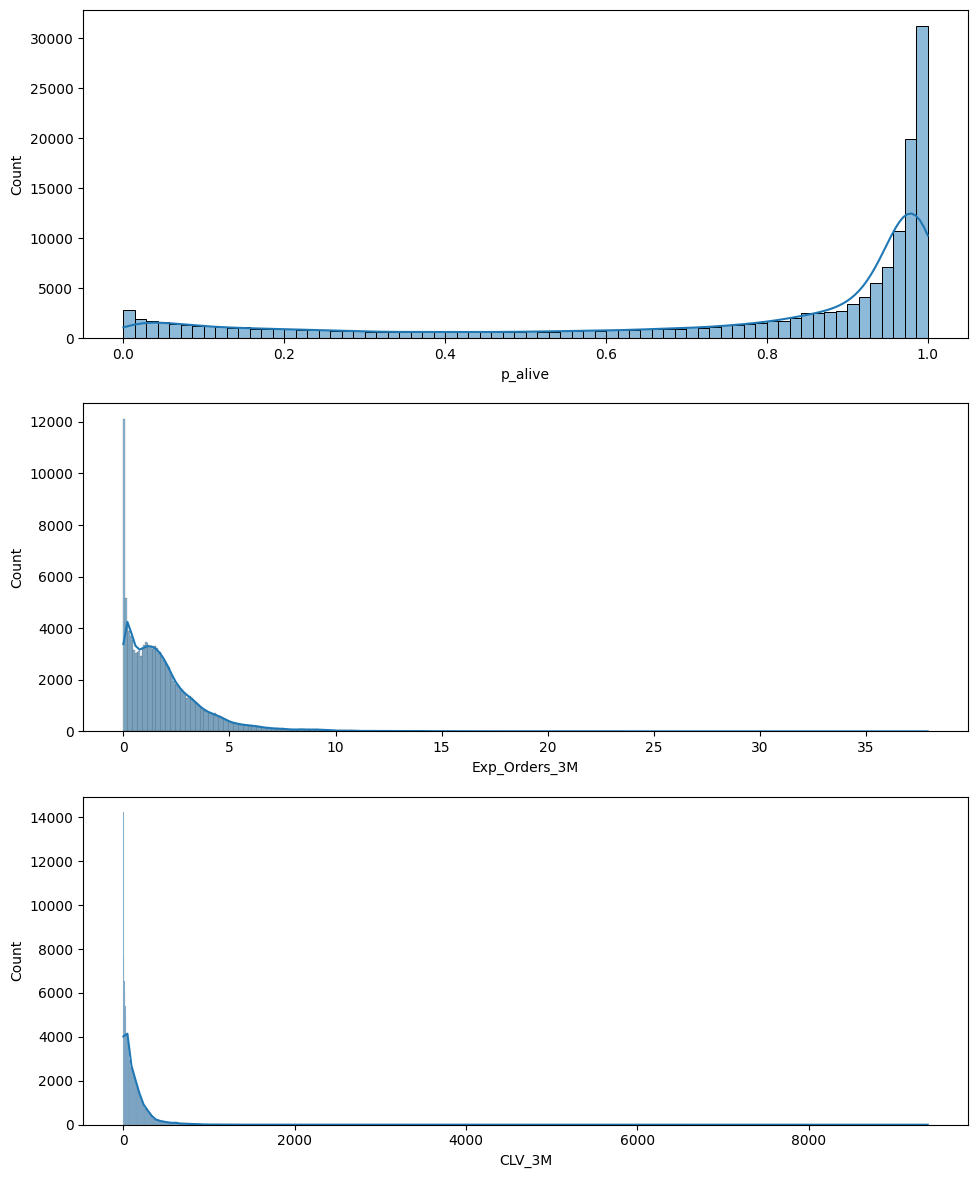

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 12))

plt.subplot(3, 1, 1)
sns.histplot(rfm.p_alive, label = 'p_alive', kde=True)

plt.subplot(3, 1, 2)
sns.histplot(rfm.Exp_Orders_3M, label = 'Exp_Orders_3M', kde=True)

plt.subplot(3, 1, 3)
sns.histplot(rfm.CLV_3M, label = 'CLV_3M', kde=True)

plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [18]:
# Apply log transformation to address skewness

# Apply log transformation to address skewness
# rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

## Pytanie - czy usuwamy uśmiercionych konsumentów ??? (p_alive == 0)
rfm_log = rfm[['Exp_Orders_3M','CLV_3M', 'p_alive']]


### K-mean clustering

In [51]:
# Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

# Store it separately for clustering
rfm_normalized = scaler.transform(rfm_log)
rfm_normalized = pd.DataFrame(rfm_normalized, columns = ['p_alive','Exp_Orders_3M','CLV_3M'])
rfm_normalized

,p_alive,Exp_Orders_3M,CLV_3M
0,0.087350,0.262182,-1.522025
1,0.323869,0.262177,-1.419136
2,3.135655,2.558676,0.027541
3,-0.143603,0.054647,-1.705977
4,0.788094,2.356092,-0.739447
...,...,...,...
150404,-0.341629,-0.137829,0.314382
150405,0.193552,0.225571,0.485863
150406,-0.033691,0.006726,0.121076
150407,0.540445,0.144917,0.763351


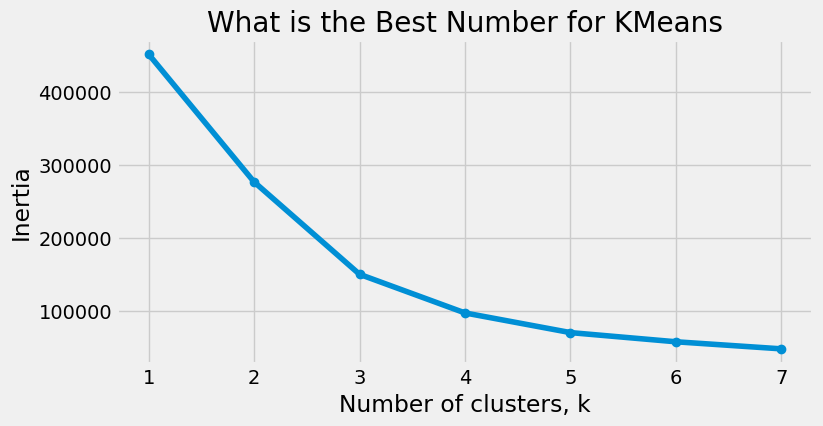

In [52]:
from sklearn.cluster import KMeans

#First : Get the Best KMeans 
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(8, 4))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.title('What is the Best Number for KMeans')
plt.show()

In [53]:
# clustering
kc = KMeans(n_clusters= 3, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'p_alive': 'mean',
                                     'Exp_Orders_3M': 'mean',
                                     'CLV_3M': 'mean'}).round(0)
rfm_normalized['CustomerID'] = rfm.index
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized


,p_alive,Exp_Orders_3M,CLV_3M,CustomerID,K_Cluster
0,0.087350,0.262182,-1.522025,0,1
1,0.323869,0.262177,-1.419136,1,1
2,3.135655,2.558676,0.027541,2,2
3,-0.143603,0.054647,-1.705977,3,1
4,0.788094,2.356092,-0.739447,4,2
...,...,...,...,...,...
150404,-0.341629,-0.137829,0.314382,150404,0
150405,0.193552,0.225571,0.485863,150405,0
150406,-0.033691,0.006726,0.121076,150406,0
150407,0.540445,0.144917,0.763351,150407,0


In [54]:
# rfm_normalized = rfm_normalized.merge(rfm.reset_index()[['CustomerID', 'RF_Seg']], on=['CustomerID'])
rfm_normalized = rfm_normalized.merge(rfm.reset_index().rename({"index":'CustomerID'}, axis =1 )[['CustomerID', 'RF_Seg']], on=['CustomerID'])

In [55]:
rfm_melt = pd.melt(rfm_normalized,
                   id_vars=['CustomerID','RF_Seg','K_Cluster'],
                   value_vars=['p_alive','Exp_Orders_3M','CLV_3M'], 
                   var_name='Metric',
                   value_name='Value')
rfm_melt.sort_values('CustomerID').head()

,CustomerID,RF_Seg,K_Cluster,Metric,Value
0,0,At Risk,1,p_alive,0.087350
300818,0,At Risk,1,CLV_3M,-1.522025
150409,0,At Risk,1,Exp_Orders_3M,0.262182
1,1,At Risk,1,p_alive,0.323869
300819,1,At Risk,1,CLV_3M,-1.419136


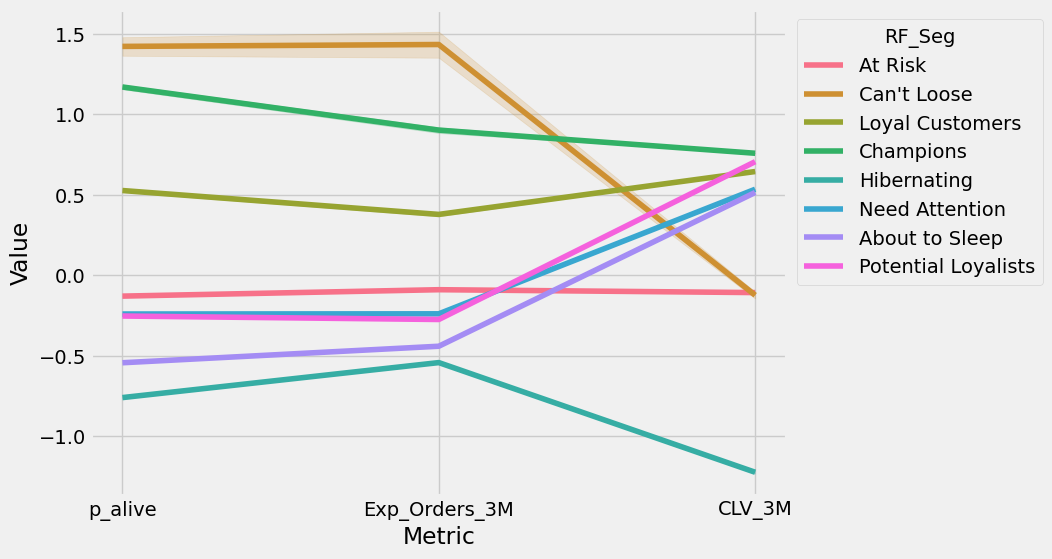

In [56]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.lineplot(x = 'Metric', y = 'Value', hue = 'RF_Seg', data = rfm_melt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

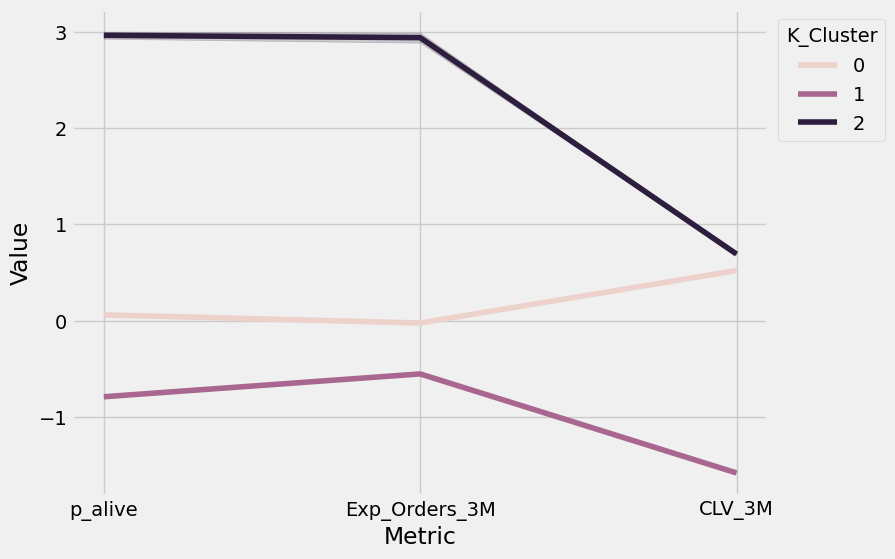

In [57]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [71]:
rfm_to_join = rfm_normalized.merge(rfm.reset_index().rename({"index":'CustomerID'}, axis =1 ).drop(['p_alive', 'Exp_Orders_3M', 'CLV_3M', 
       'RF_Seg'], axis = 1), on=['CustomerID'])
rfm_to_join = rfm_to_join[["Data", "Dystrybutor", "Towar", "K_Cluster"]]
rfm_to_join
clv_warzywa_2 = clv_warzywa.merge(rfm_to_join,  on=["Data", "Dystrybutor", "Towar"] )
clv_warzywa_2

,Dystrybutor,Towar,Przedstawiciel,Data,p_alive,monetary_value,Exp_Orders_3M,CLV_3M,K_Cluster
0,Bio Ananasy i Cebule Magazyn,Jabłka,Aleksandra Szymańska,2022-01-17,0.319,74.700000,2.528,217.557041,1
1,Ekologiczne Ananasy i Brokuły Firma,Pomidory malinowe,Wojciech Jankowski,2022-01-17,0.355,59.800000,3.056,213.336305,1
2,Ekologiczne Maliny i Szpinak Sp. z o.o.,Ziemniaki,Jan Wolski,2022-01-17,0.762,70.300000,8.213,620.380832,2
3,Ekologiczne Mandarynki i Sałata Firma,Jabłka,Mateusz Kowalczyk,2022-01-17,0.255,74.700000,2.025,174.212932,1
4,Ekologiczne Pomarańcze i Dynie Sp. z o.o.,Ziemniaki,Krzysztof Kowalewski,2022-01-17,0.566,149.500000,3.912,655.609330,2
...,...,...,...,...,...,...,...,...,...
145737,Świeże Wiśnie i Sałata Magazyn,Pomidory koktajlowe,Aleksandra Szymańska,2023-12-25,0.847,73.900000,1.258,105.261522,0
145738,Świeże Wiśnie i Szpinak Firma,Ziemniaki,Aleksandra Szymańska,2023-12-25,0.903,74.280952,2.412,180.225485,0
145739,Świeże Wiśnie i Szpinak Sp. z o.o.,Cebula,Michał Dąbrowski,2023-12-25,0.783,65.900000,1.912,134.482278,0
145740,Świeże Wiśnie i Warzywa Hurtownia,Jabłka,Krzysztof Kowalewski,2023-12-25,0.994,51.528000,3.165,164.040820,0


## Analiza portfela dystrybutorów przy wykorzystaniu flag

In [26]:
def clv_week(df, start_date, clv_horizons = [3], level=['Dystrybutor']):
    
    min_date = pd.to_datetime(df['Data'].min())
    max_date = pd.to_datetime(df['Data'].max())
    df['Data'] = pd.to_datetime(df['Data'])
    
    clv_all = pd.DataFrame()
    date_range = pd.date_range(start = start_date, end = max_date, freq="W-MON") 
    # print(date_range)
    
    for date in date_range:
        df_clv = df.loc[(df['Data']<=date)] 
        
        if 'Towar' in level: 
            df_clv['Dystrybutor_Towar_Przedstawiciel'] = df_clv['Dystrybutor'] + '$' + df_clv['Towar'] + '$' + df_clv['Przedstawiciel']
        else: 
            df_clv['Dystrybutor_Towar_Przedstawiciel'] = df_clv['Dystrybutor'] + '$' + df_clv['Przedstawiciel']

        clv = lifetimes.utils.summary_data_from_transaction_data(df_clv, 'Dystrybutor_Towar_Przedstawiciel', 'Data', 'Quantity')
        clv = clv.loc[clv['monetary_value']>0]
        
        bg_fitter = BetaGeoFitter(penalizer_coef=0.01)
        bg_fitter.fit(clv['frequency'], clv['recency'], clv['T'])
        
        pareto_fitter = ParetoNBDFitter(penalizer_coef = 0.01)
        pareto_fitter.fit(clv["frequency"], clv["recency"], clv["T"])
        
        ggf = GammaGammaFitter(penalizer_coef=0.01)
        ggf.fit(clv["frequency"], clv["monetary_value"])
        
        clv['Data'] = date
        clv['p_alive'] = bg_fitter.conditional_probability_alive(clv["frequency"], clv["recency"], clv["T"]).round(3)

        for clv_horizon in clv_horizons:
            clv['Exp_Orders_'+str(clv_horizon)+'M'] = bg_fitter.conditional_expected_number_of_purchases_up_to_time(clv_horizon*30, clv['frequency'].values, clv['recency'], clv['T']).round(3)            
            clv['CLV_'+str(clv_horizon)+'M'] = ggf.customer_lifetime_value(bg_fitter, clv["frequency"], clv["recency"], clv["T"], clv["monetary_value"],
                                                                                         time = clv_horizon, freq = 'D', discount_rate=0)
            
        clv.drop(columns = ['frequency', 'recency', 'T'], errors='ignore', inplace=True)

        if date==date_range[0]:
            clv_all = clv.copy()
        else: 
            clv_all = pd.concat([clv_all, clv], axis=0)
    
    clv_all = clv_all.reset_index()

    if 'Towar' in level:
        clv_all['Dystrybutor'] = clv_all['Dystrybutor_Towar_Przedstawiciel'].str.split('$').str[0]
        clv_all['Towar'] = clv_all['Dystrybutor_Towar_Przedstawiciel'].str.split('$').str[1]
        clv_all['Przedstawiciel'] = clv_all['Dystrybutor_Towar_Przedstawiciel'].str.split('$').str[2]
        clv_all.drop(columns=['Dystrybutor_Towar_Przedstawiciel'], inplace=True)
        clv_all = clv_all[['Dystrybutor', 'Towar', 'Przedstawiciel', 'Data', 'p_alive', 'monetary_value'] + clv_all.filter(regex='Exp|CLV|Sales').columns.tolist()] 
    else:
        clv_all.rename(columns = {'Dystrybutor_Towar_Przedstawiciel':'Dystrybutor'}, inplace=True)
    
    return clv_all

In [27]:
clv_warzywa = clv_week(df = df, start_date = '2022-01-15', clv_horizons = [3], level=['Dystrybutor', 'Towar'])

In [28]:
# clv_warzywa
clv_przedstawiciel = clv_warzywa.loc[clv_warzywa['Przedstawiciel']=='Zuzanna Kowalska']

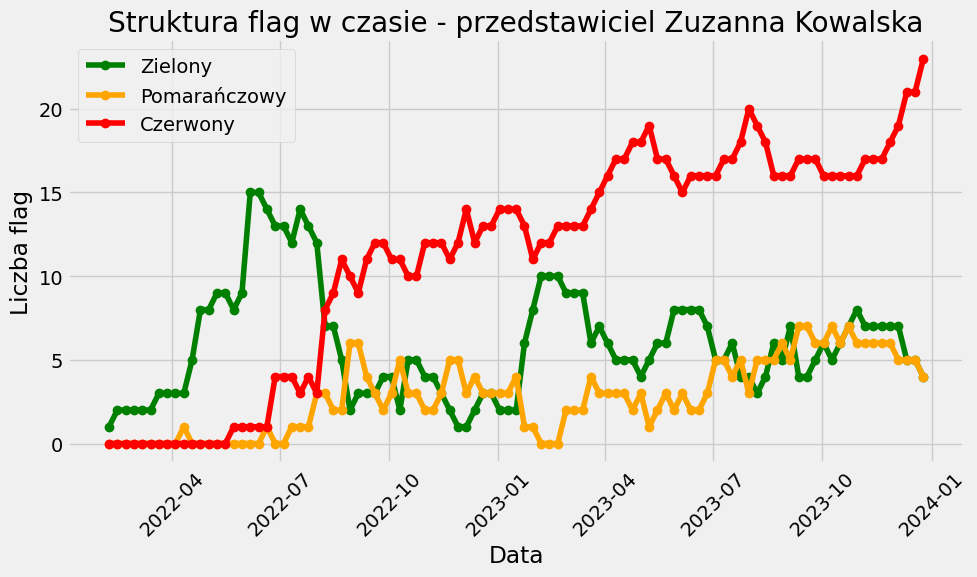

In [29]:
green_counts = {}
orange_counts = {}
red_counts = {}
przedstawiciel = clv_przedstawiciel['Przedstawiciel'].tolist()[0]

dystrybutorzy_towary = (clv_przedstawiciel['Dystrybutor']+'$'+clv_przedstawiciel['Towar']).unique()

for dystr_tow in dystrybutorzy_towary:
    dystrybutor, towar = dystr_tow.split('$')
    
    clv_przedstawiciel_w = clv_przedstawiciel.loc[(clv_przedstawiciel['Dystrybutor'] == dystrybutor) & (clv_przedstawiciel['Towar'] == towar)]
    
    clv_przedstawiciel_w['CLV_3M_Mean'] = clv_przedstawiciel_w['CLV_3M'].rolling(window=10).mean()
    
    clv_przedstawiciel_w['Color'] = clv_przedstawiciel_w.apply(lambda row: 'red' if row['CLV_3M'] < 0.9 * row['CLV_3M_Mean']
                                                     else 'orange' if row['CLV_3M'] < row['CLV_3M_Mean']
                                                     else 'green', axis=1)
    clv_przedstawiciel_w['Color'] = clv_przedstawiciel_w.apply(lambda row: 'red' if row['CLV_3M'] < 0.9 * row['CLV_3M_Mean']
                                                     else 'orange' if row['CLV_3M'] < row['CLV_3M_Mean']
                                                     else 'green', axis=1)
    
    for date, color_group in clv_przedstawiciel_w.groupby('Data')['Color']:
        green_counts[date] = color_group.tolist().count('green') if date not in green_counts else green_counts[date] + color_group.tolist().count('green')
        orange_counts[date] = color_group.tolist().count('orange') if date not in orange_counts else orange_counts[date] + color_group.tolist().count('orange')
        red_counts[date] = color_group.tolist().count('red') if date not in red_counts else red_counts[date] + color_group.tolist().count('red')

    color_table = pd.DataFrame({'Data': list(green_counts.keys()),
                            'Liczba zielonych': list(green_counts.values()),
                            'Liczba pomarańczowych': list(orange_counts.values()),
                            'Liczba czerwonych': list(red_counts.values())})
    # color_table["month"] = color_table["Data"].dt.month
    color_table_2 = color_table.copy()
    color_table_2['Month'] = color_table_2['Data'] - pd.offsets.MonthBegin(1)
    color_table_2.drop("Data", axis = 1, inplace = True)
    color_table_2 = color_table_2.groupby('Month').sum()
    color_table_2 = color_table_2.diff().fillna(0)
    color_table_2.reset_index(inplace = True)

dates = list(green_counts.keys())
green_counts_values = list(green_counts.values())
orange_counts_values = list(orange_counts.values())
red_counts_values = list(red_counts.values())

# Tworzenie wykresu z trzema seriami danych przedstawiającymi liczbę poszczególnych kolorów w czasie
plt.figure(figsize=(10, 6))
plt.plot(dates, green_counts_values, label='Zielony', color='green', marker='o')
plt.plot(dates, orange_counts_values, label='Pomarańczowy', color='orange',  marker='o')
plt.plot(dates, red_counts_values, label='Czerwony', color='red',  marker='o')
plt.title(f'Struktura flag w czasie - przedstawiciel {przedstawiciel}')
plt.xlabel('Data')
plt.ylabel('Liczba flag')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Pierwsze różnice pozwalają po miesiącach pozwalają uniknąć problemu akumulujących się "nieżywych" klientów

In [30]:
color_table_2.head()

,Month,Liczba zielonych,Liczba pomarańczowych,Liczba czerwonych
0,2022-02-01,0.0,0.0,0.0
1,2022-03-01,3.0,0.0,0.0
2,2022-04-01,9.0,1.0,0.0
3,2022-05-01,24.0,-1.0,2.0
4,2022-06-01,14.0,1.0,5.0


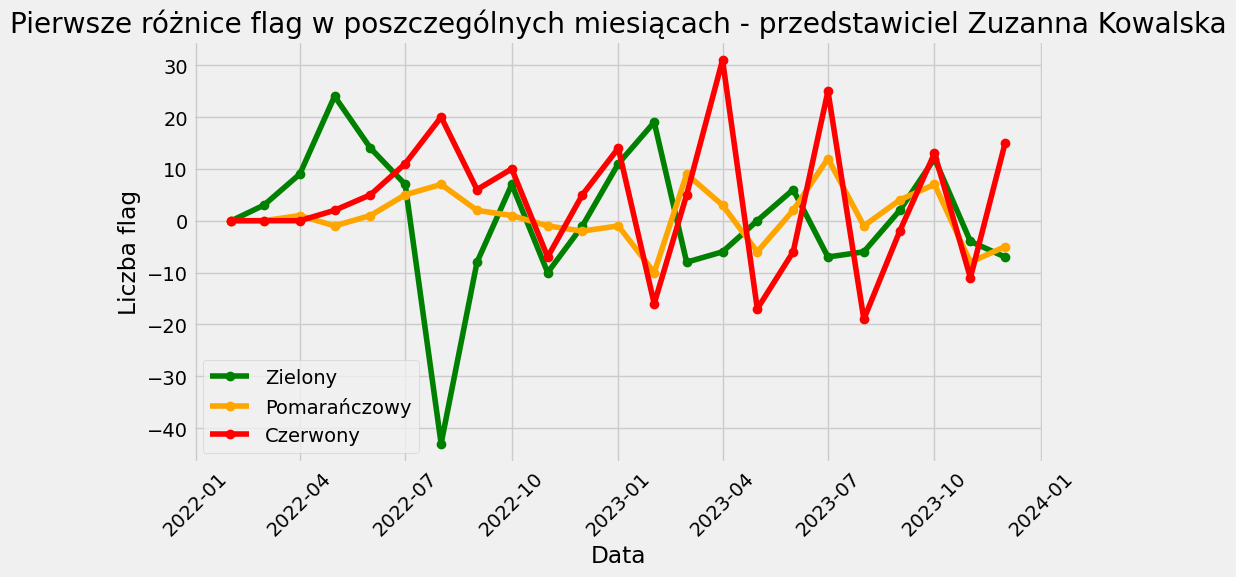

In [31]:

# Tworzenie wykresu z trzema seriami danych przedstawiającymi liczbę poszczególnych kolorów w czasie
plt.figure(figsize=(10, 6))
plt.plot(color_table_2['Month'], color_table_2['Liczba zielonych'], label='Zielony', color='green', marker='o')
plt.plot(color_table_2['Month'], color_table_2['Liczba pomarańczowych'], label='Pomarańczowy', color='orange',  marker='o')
plt.plot(color_table_2['Month'], color_table_2['Liczba czerwonych'], label='Czerwony', color='red',  marker='o')
plt.title(f'Pierwsze różnice flag w poszczególnych miesiącach - przedstawiciel {przedstawiciel}')
plt.xlabel('Data')
plt.ylabel('Liczba flag')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


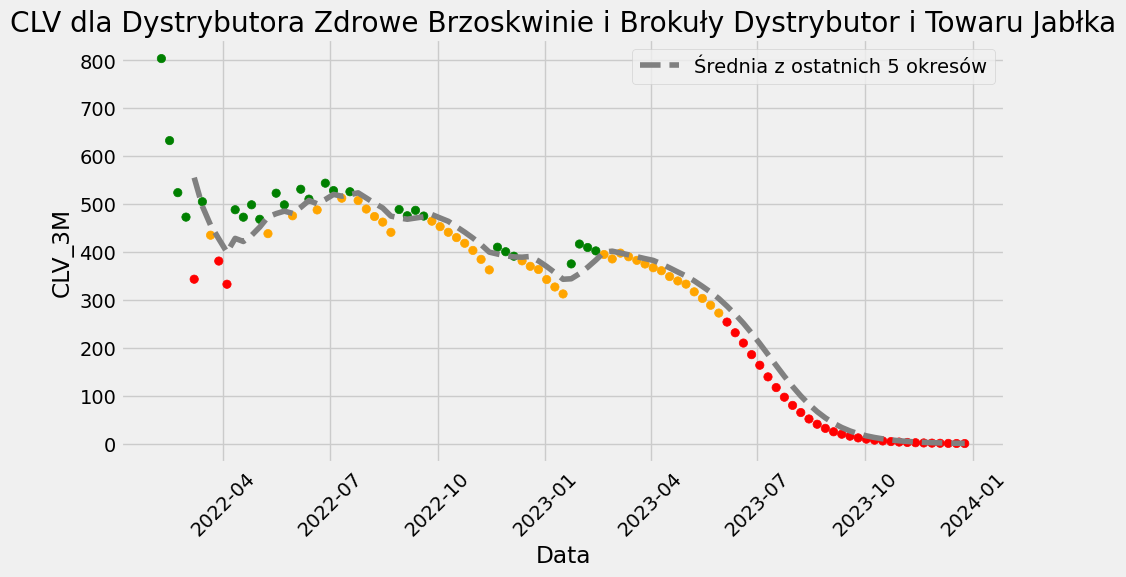

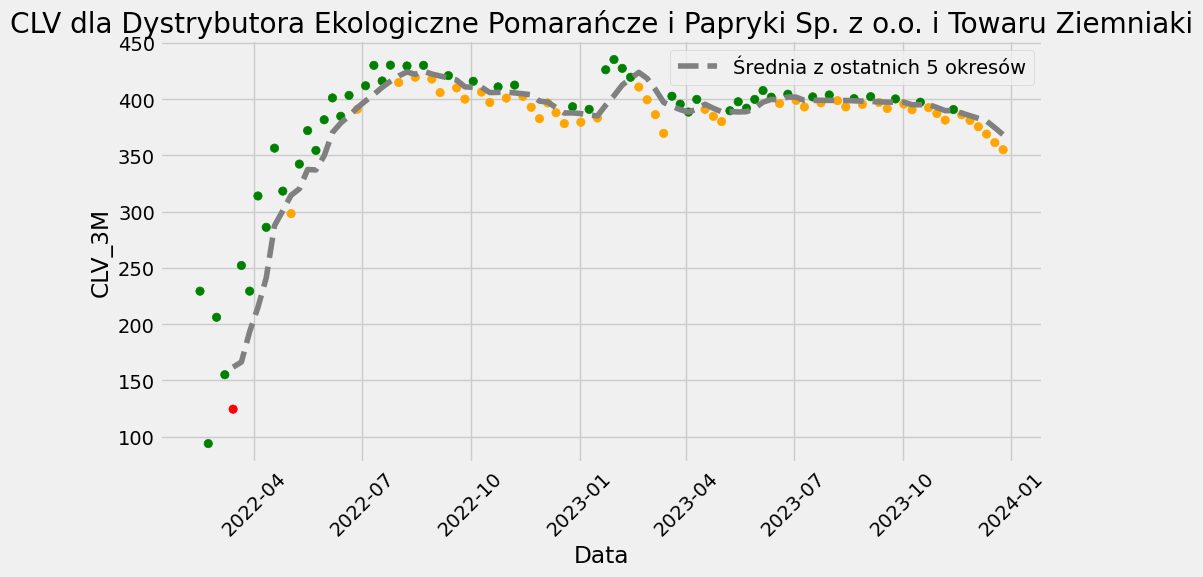

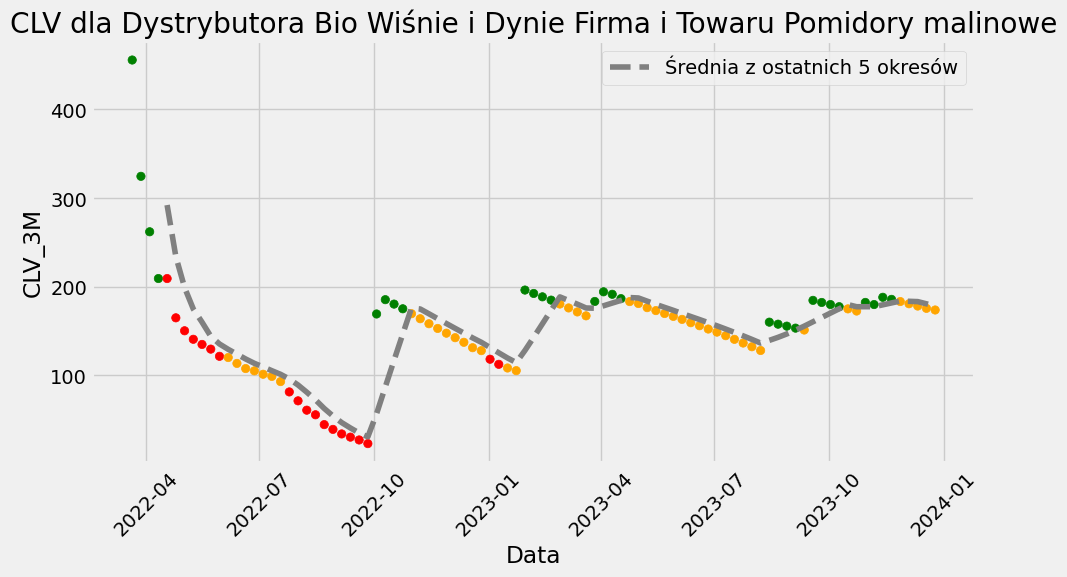

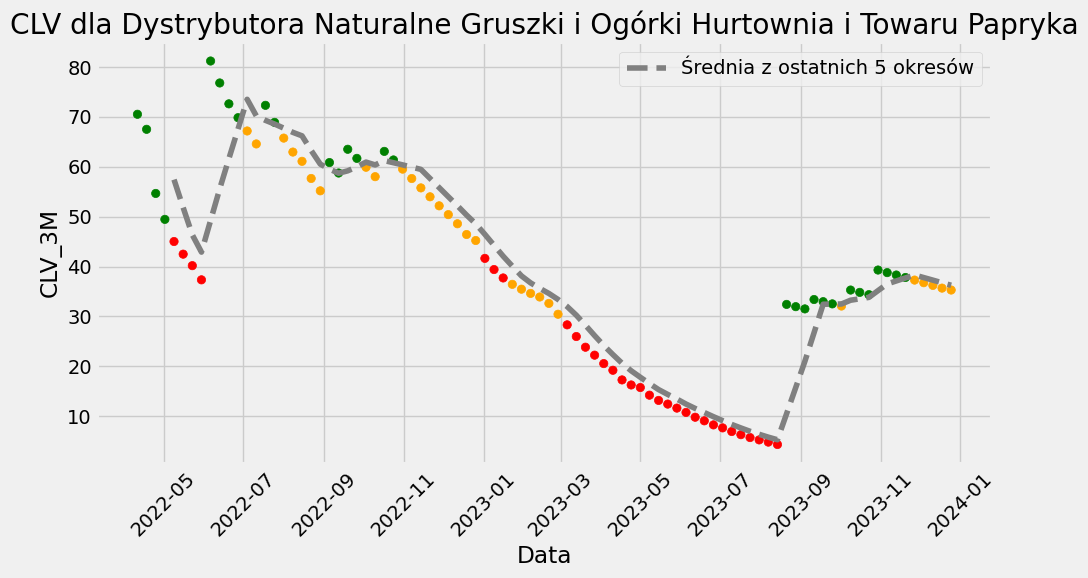

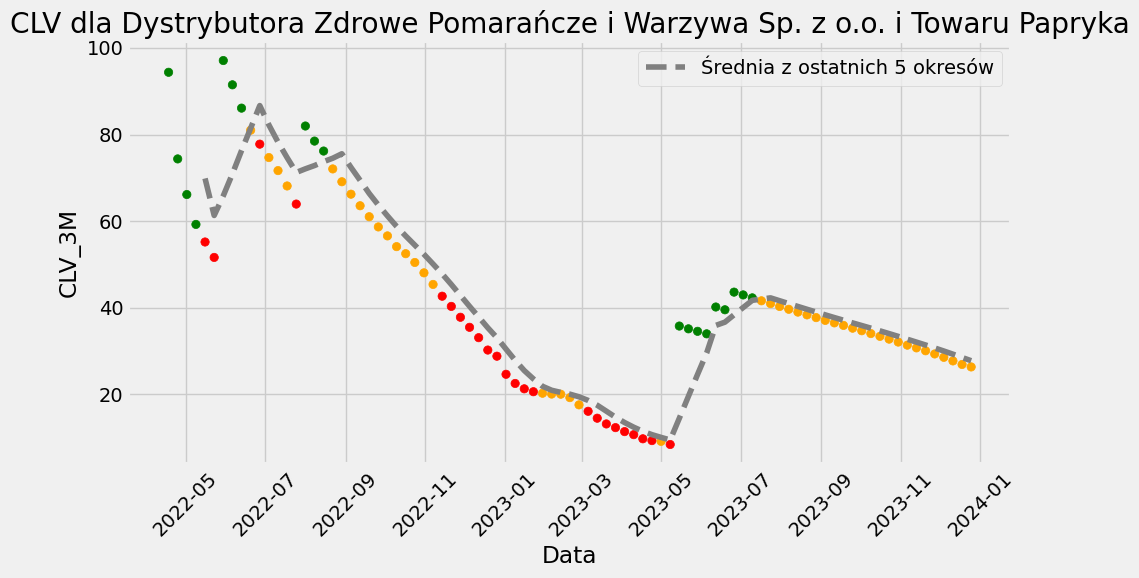

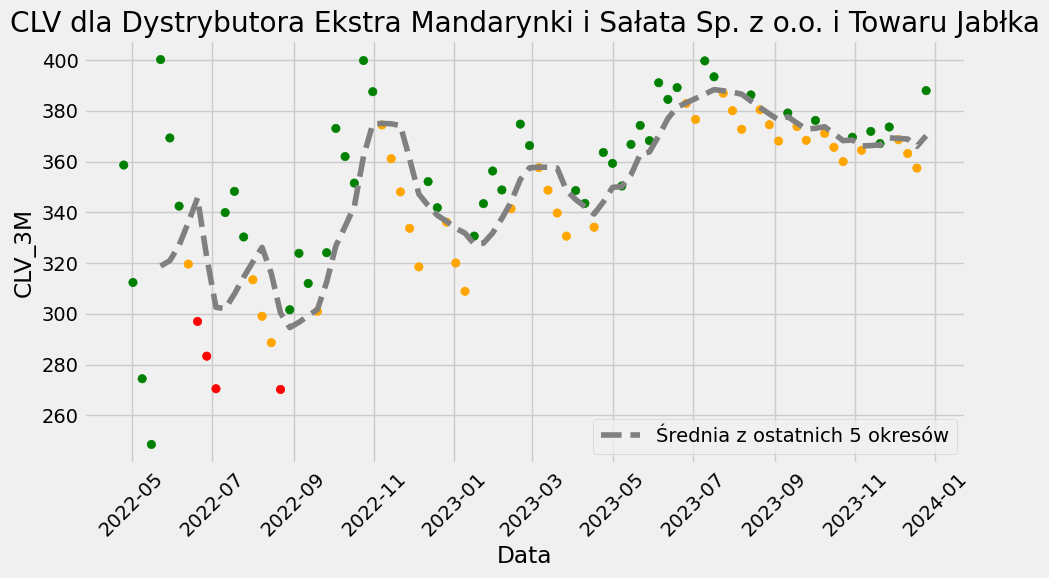

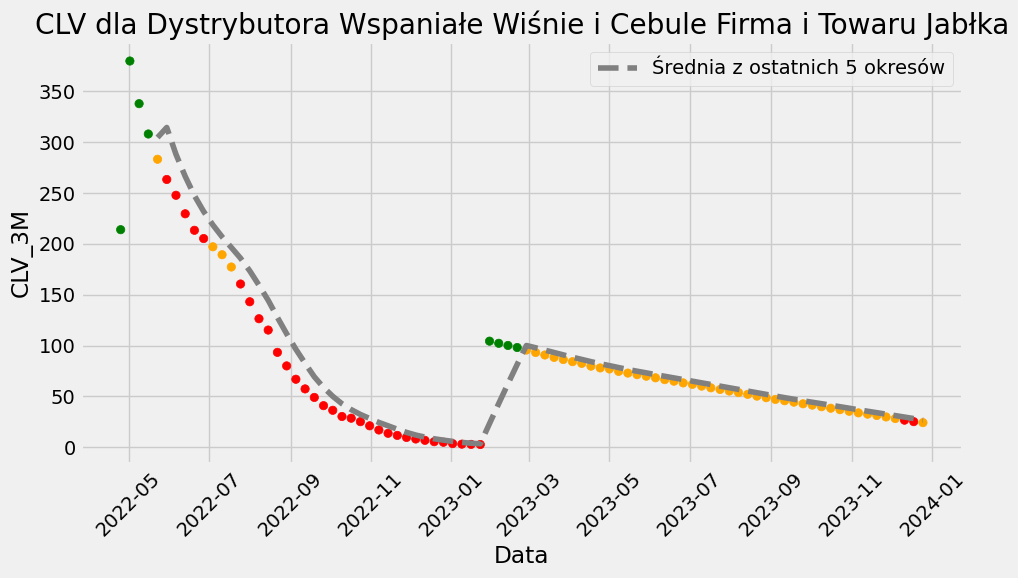

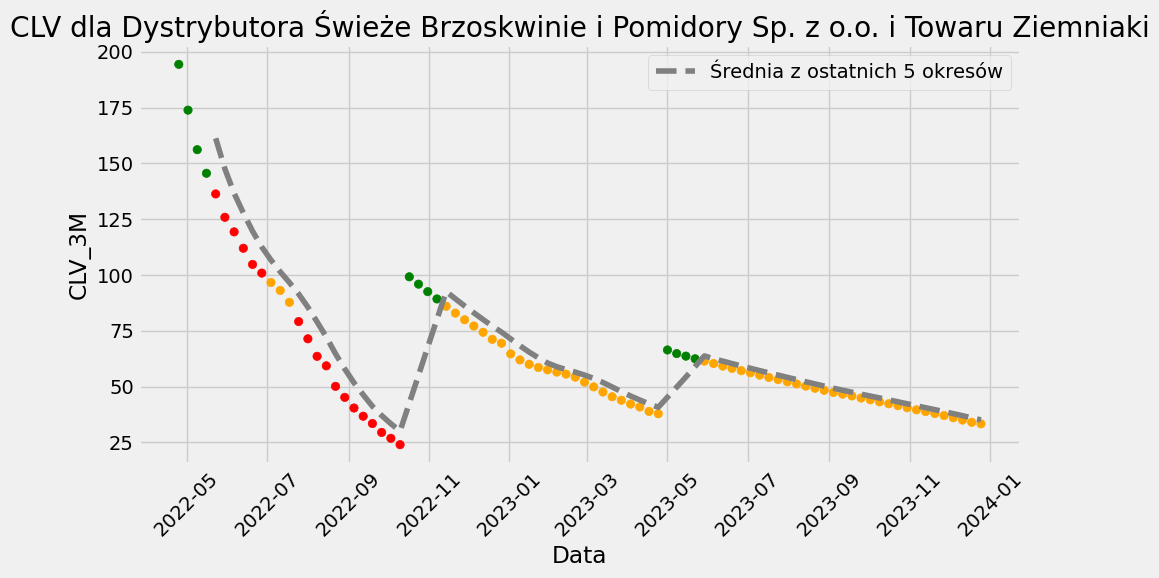

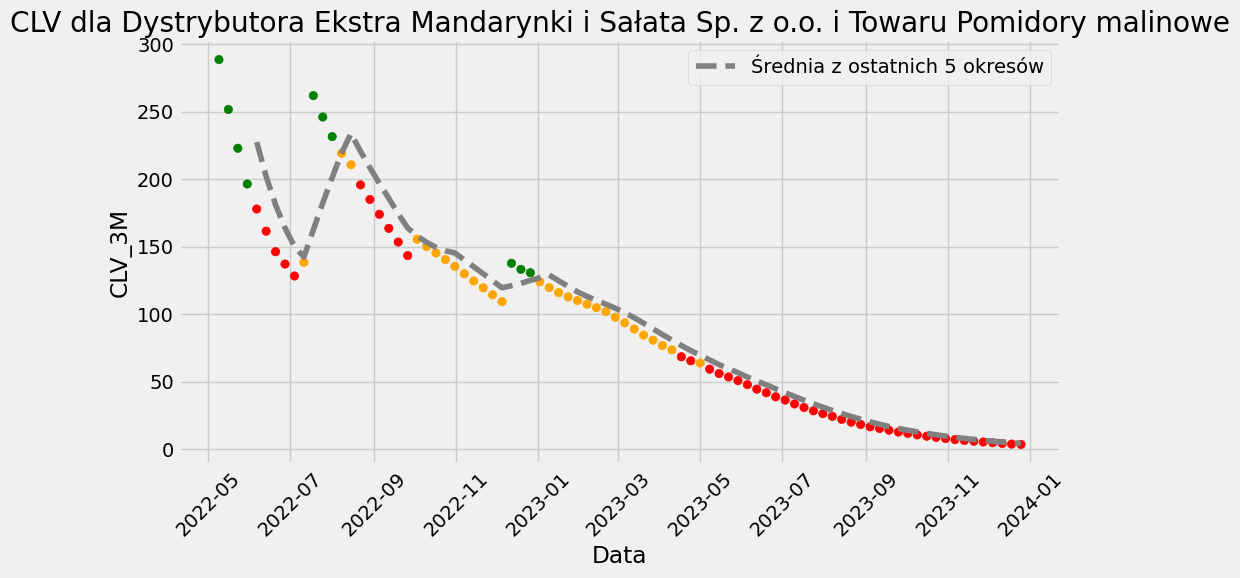

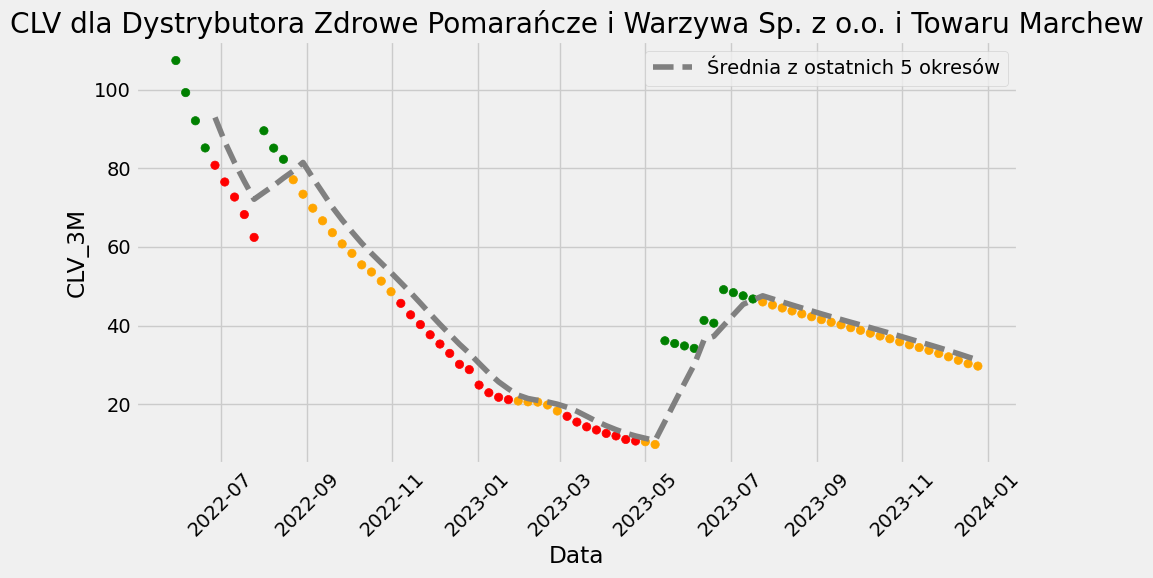

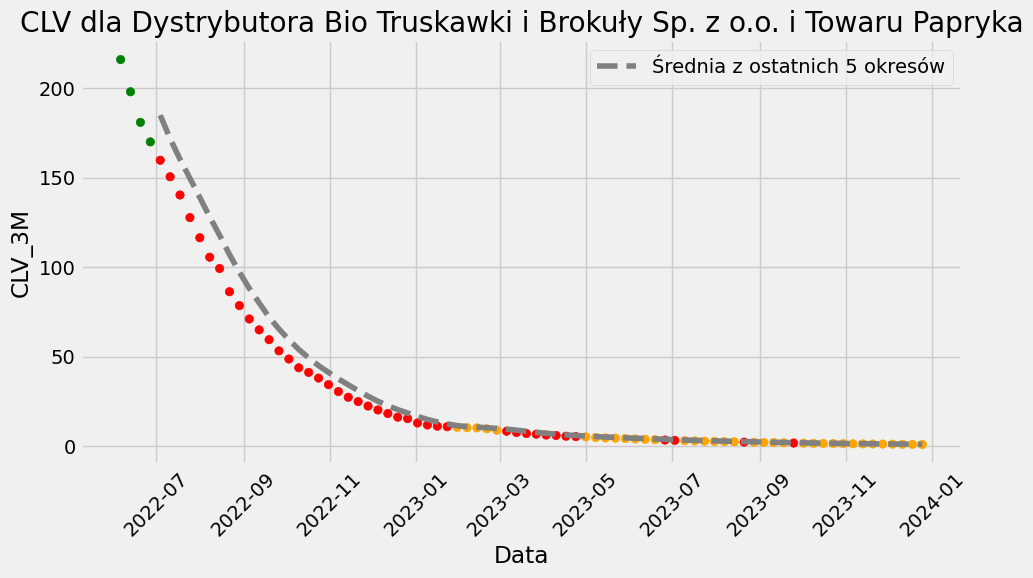

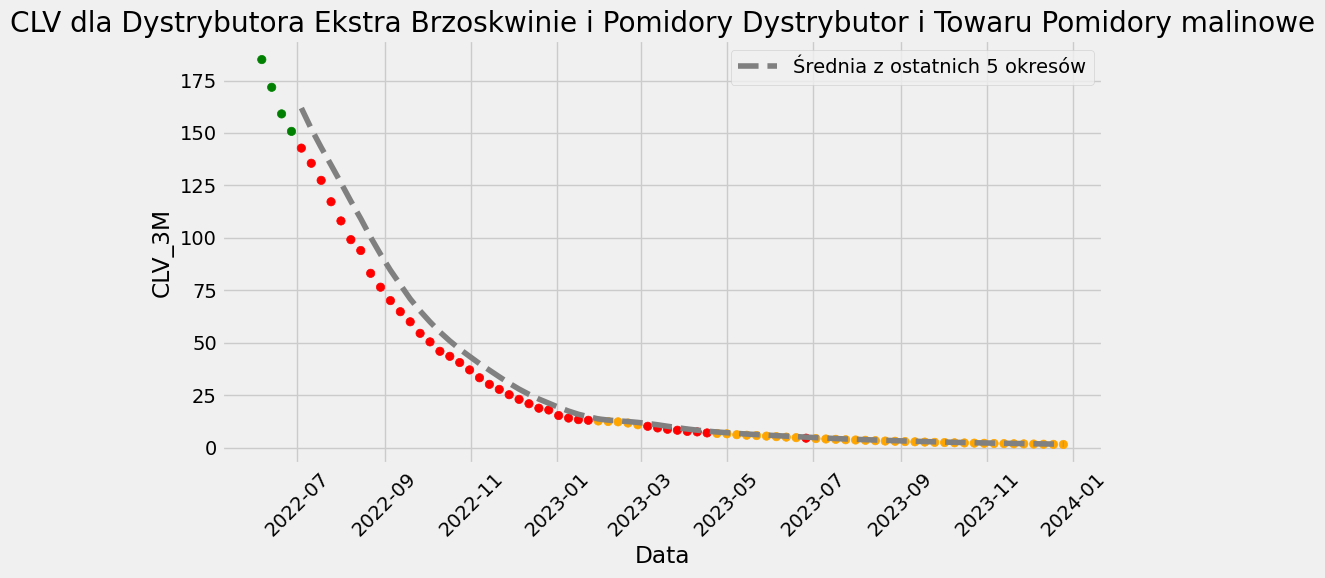

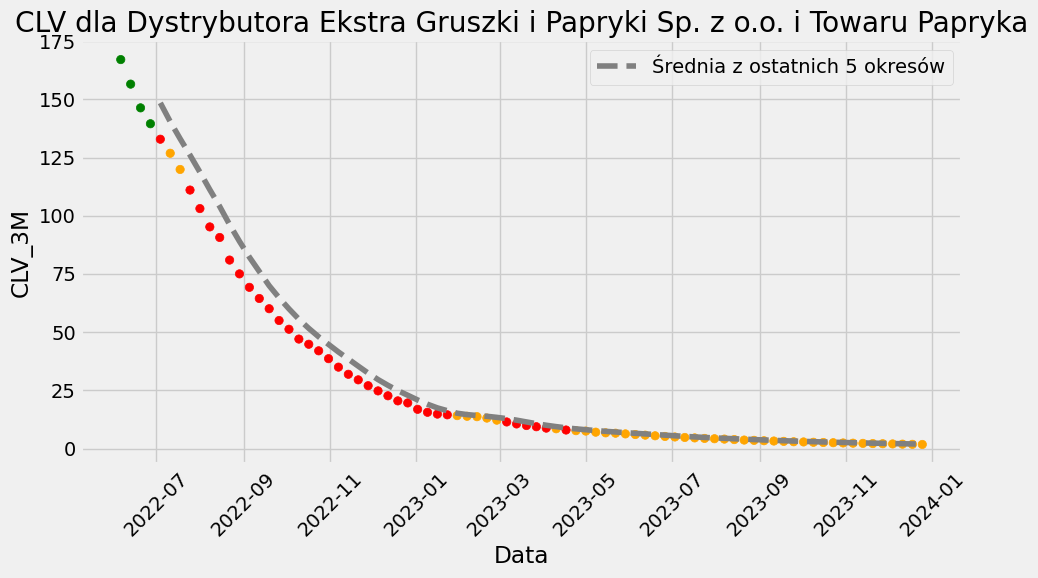

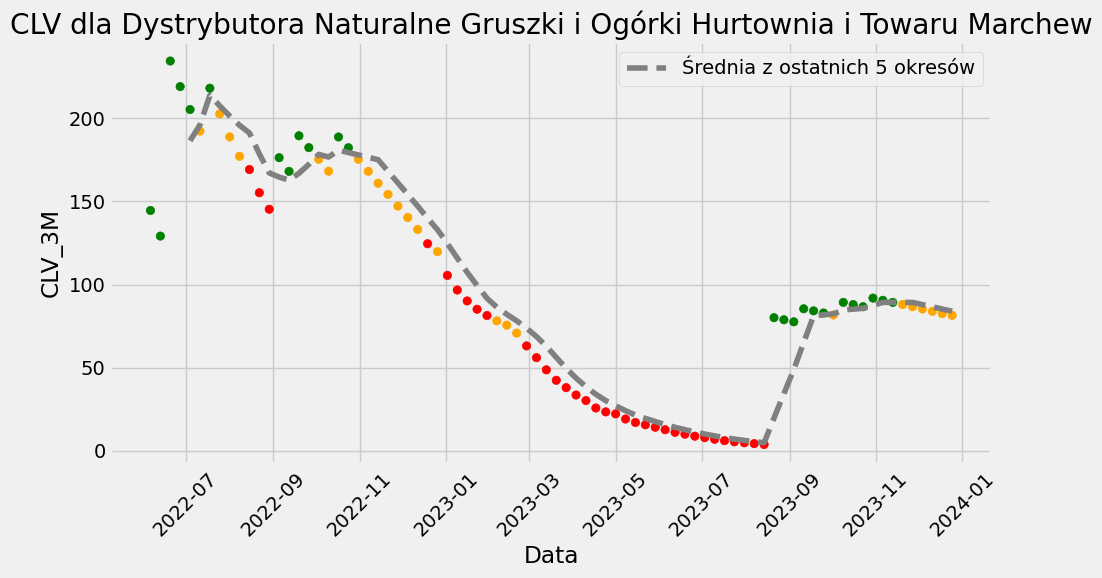

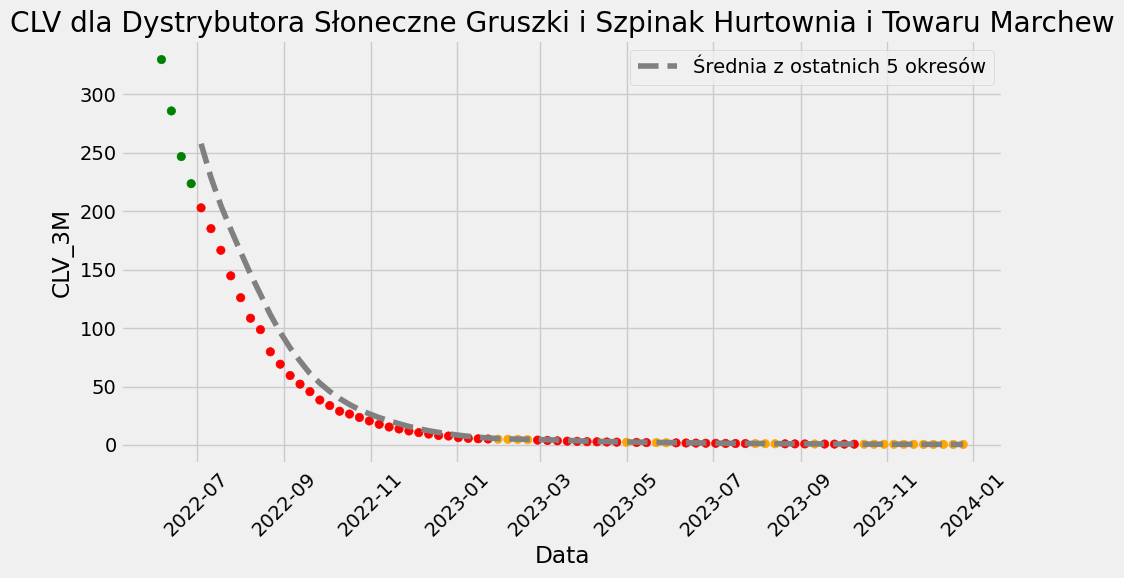

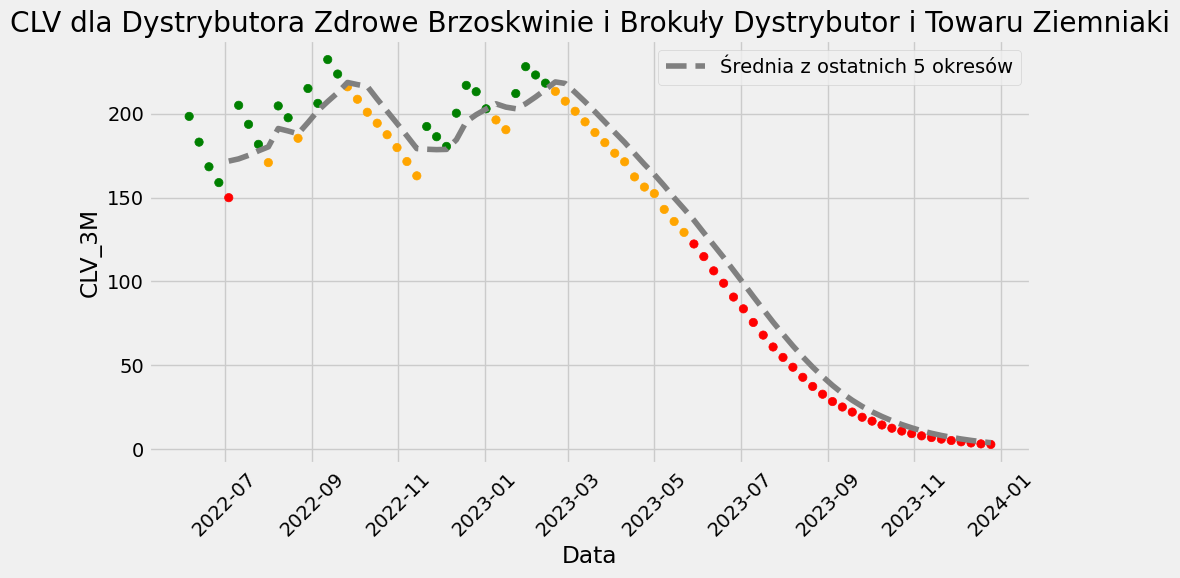

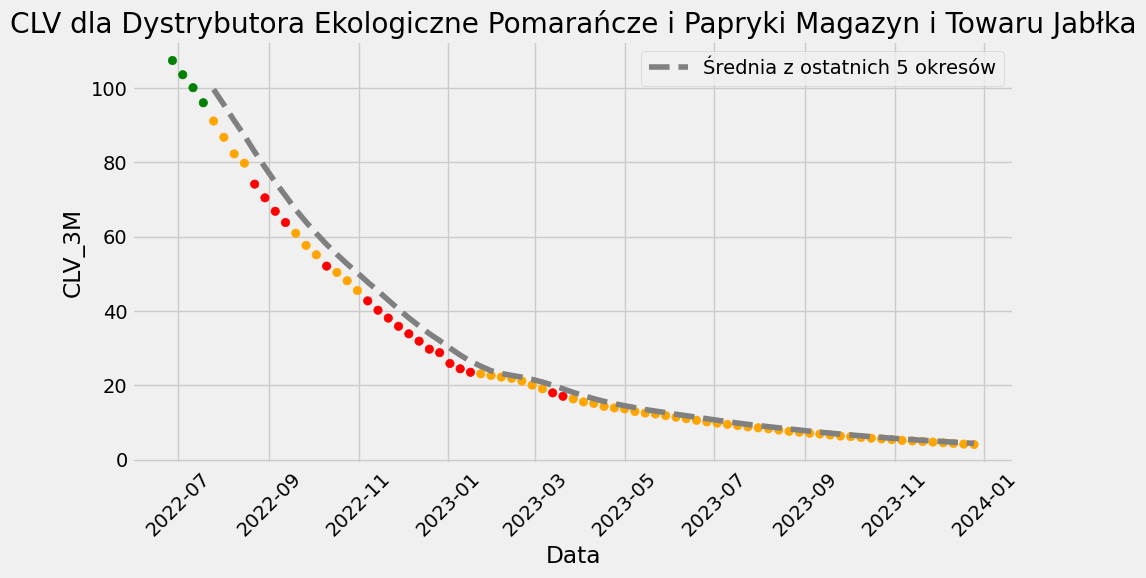

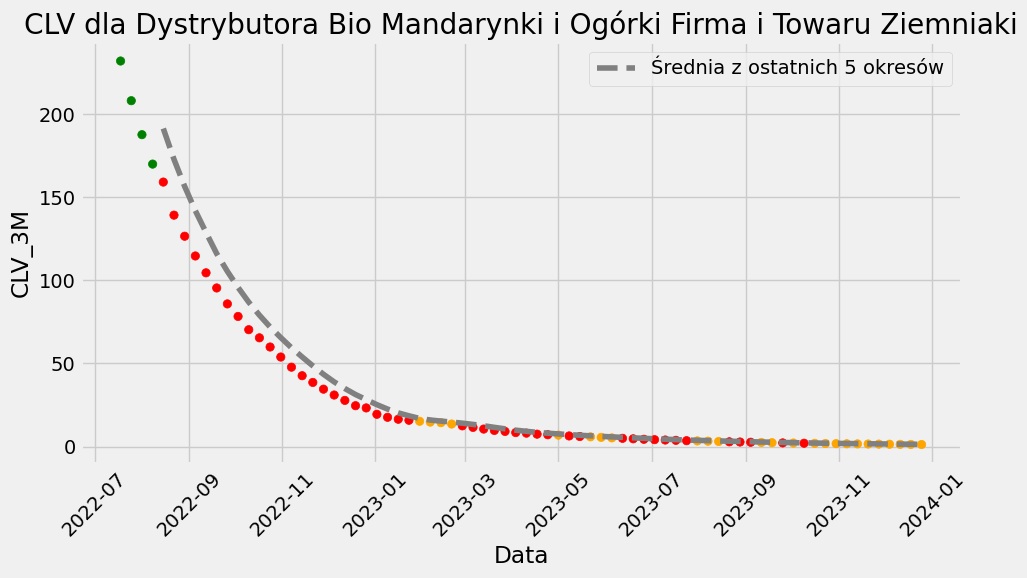

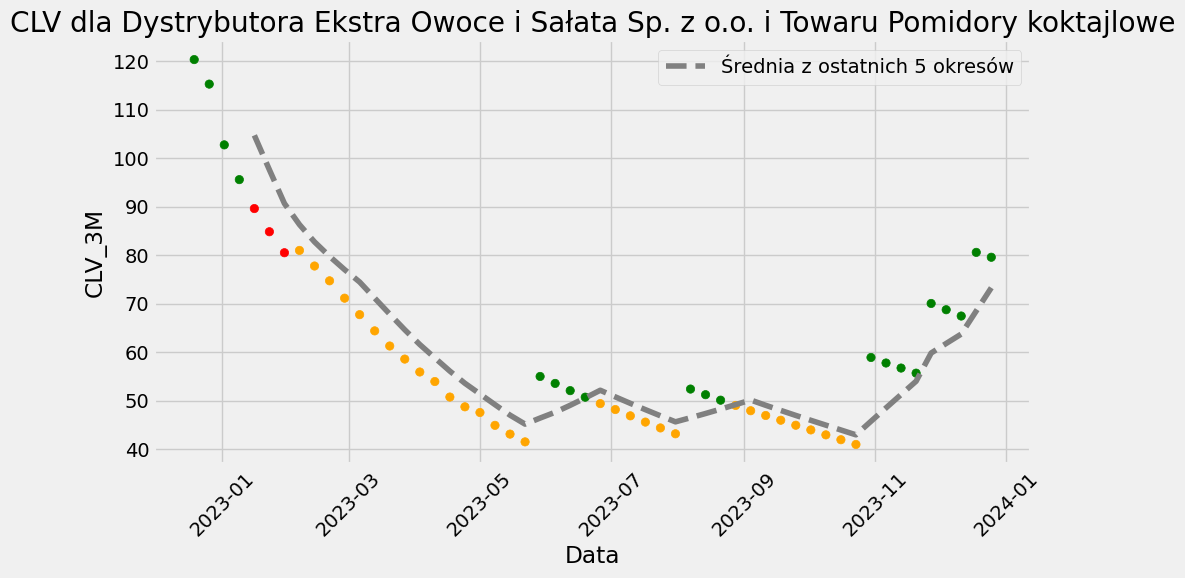

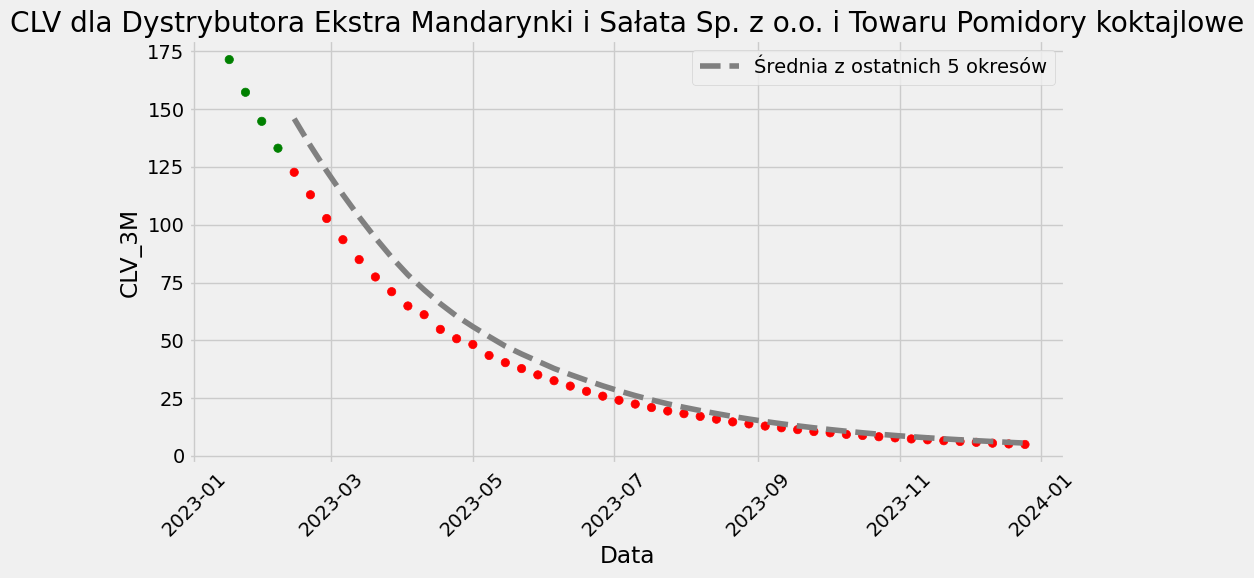

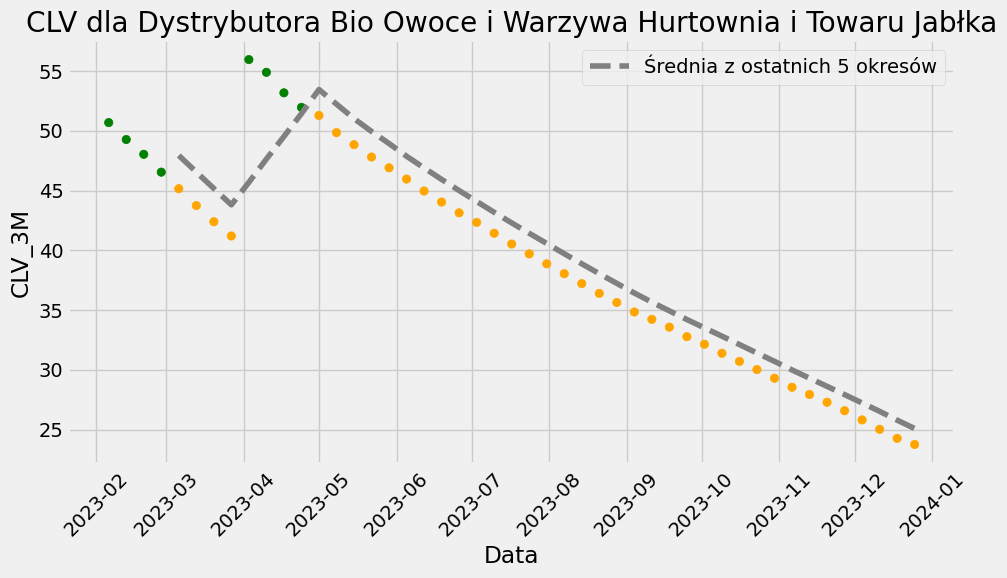

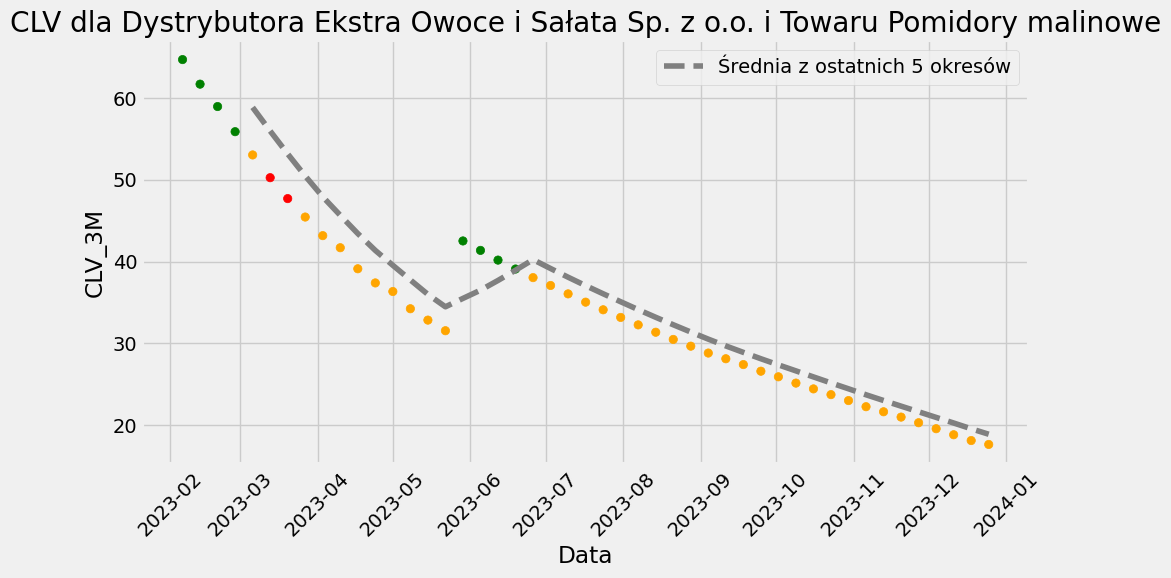

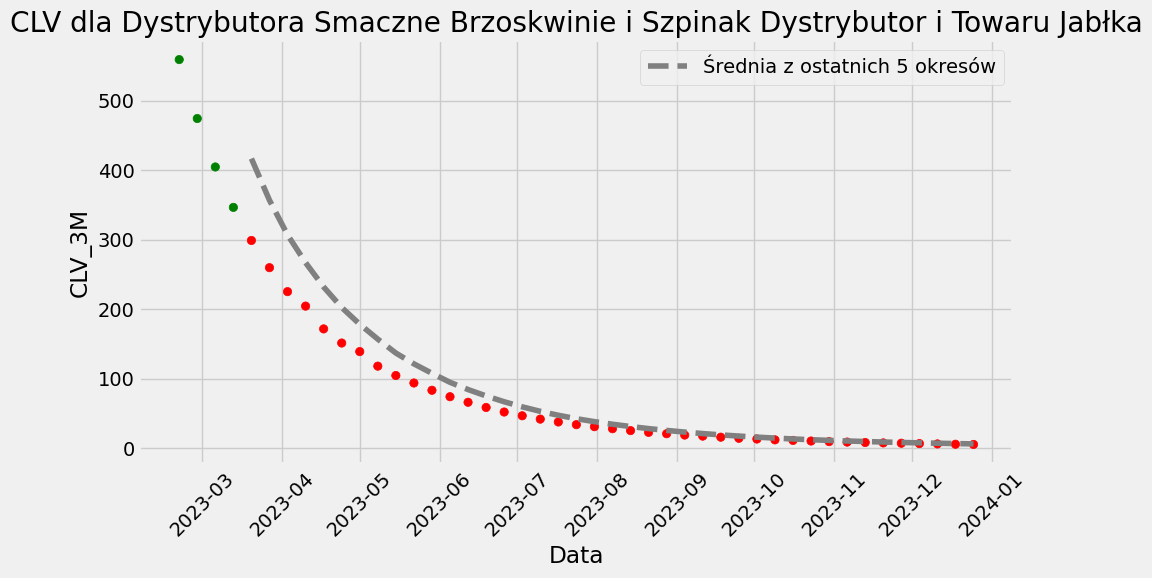

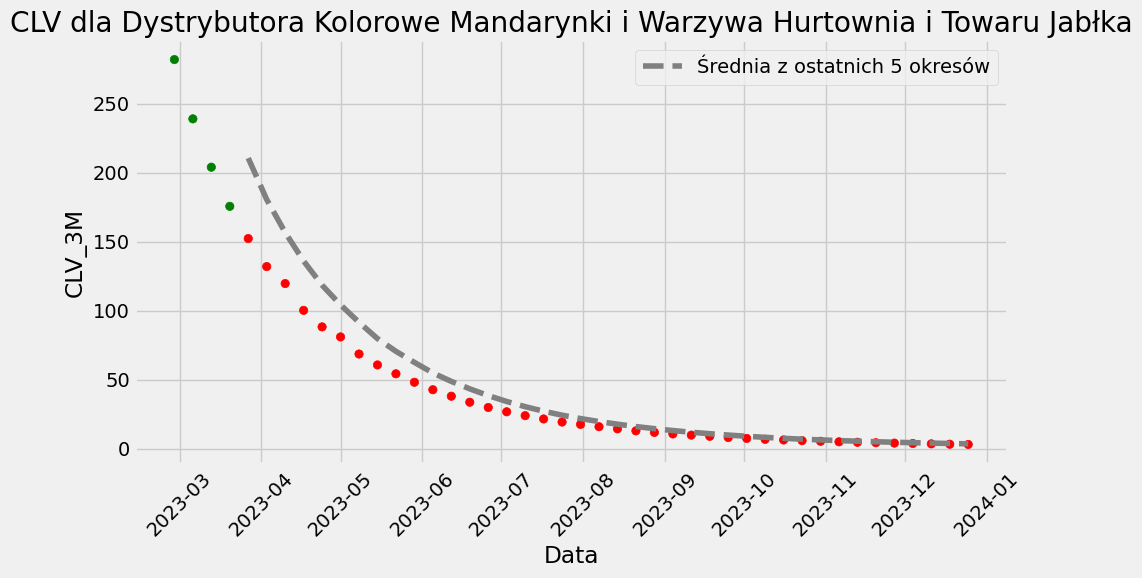

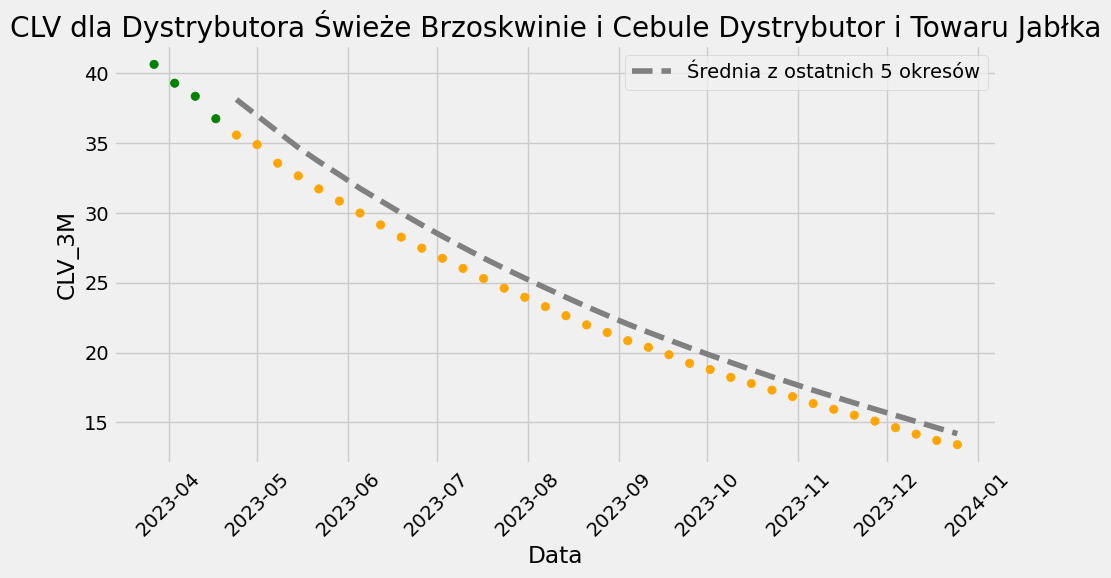

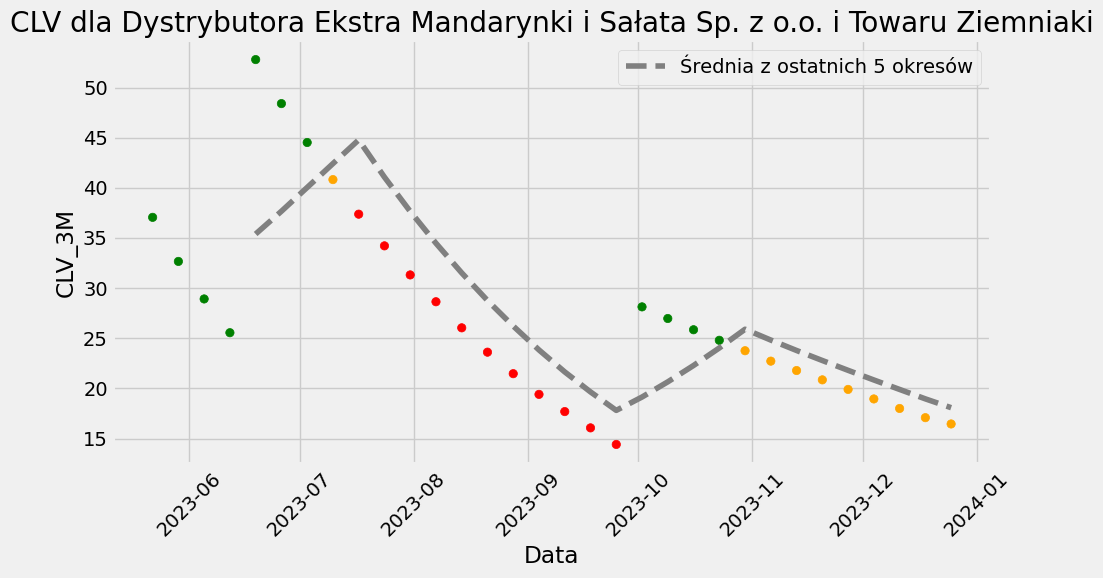

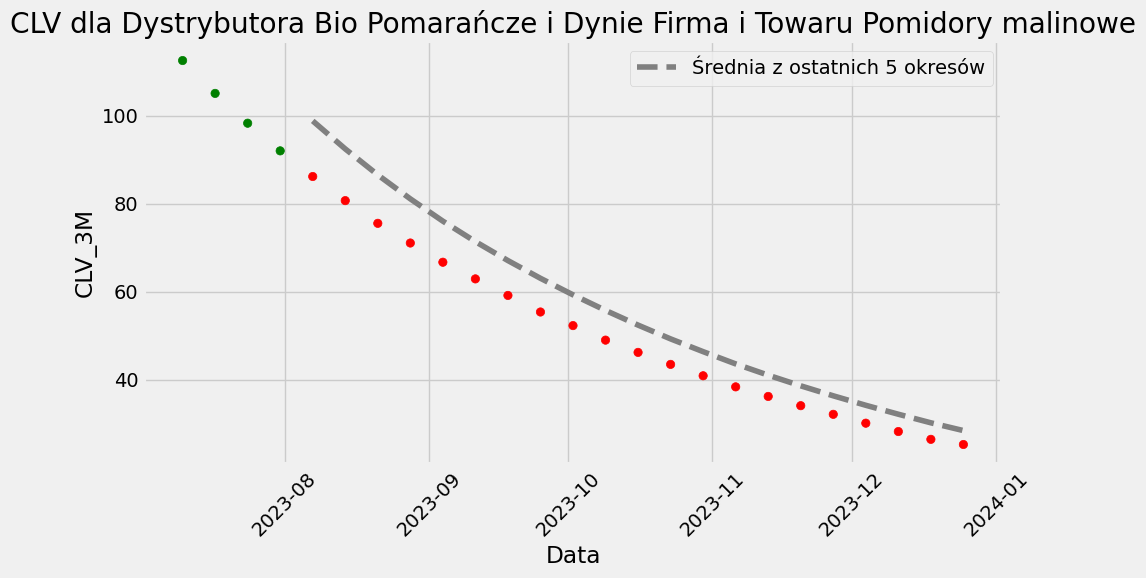

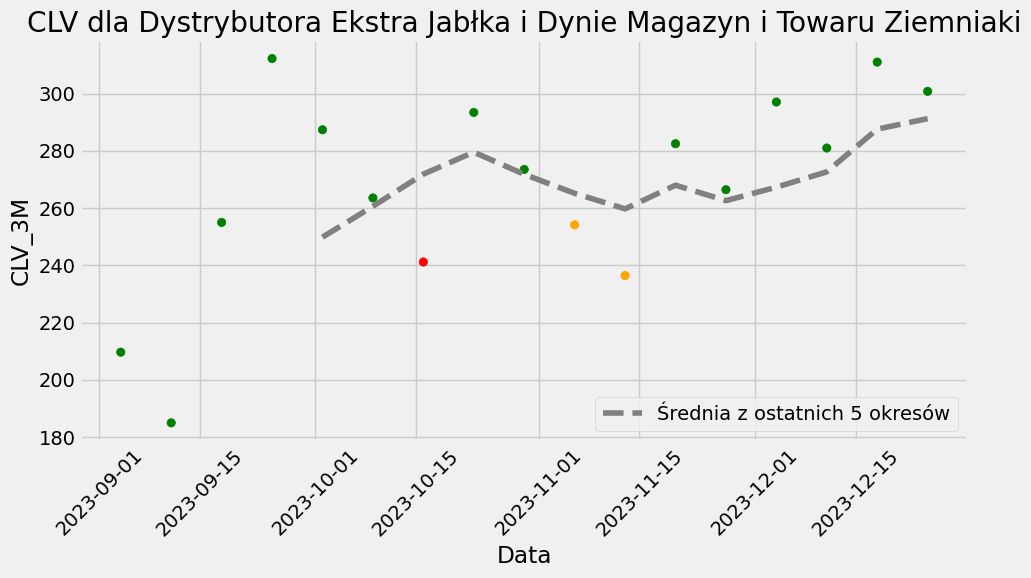

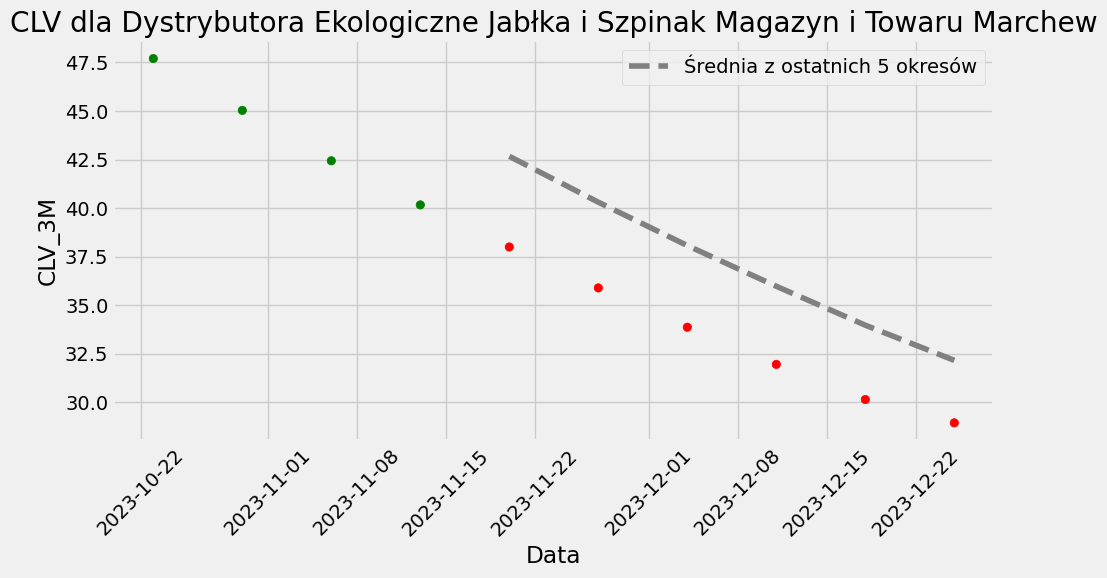

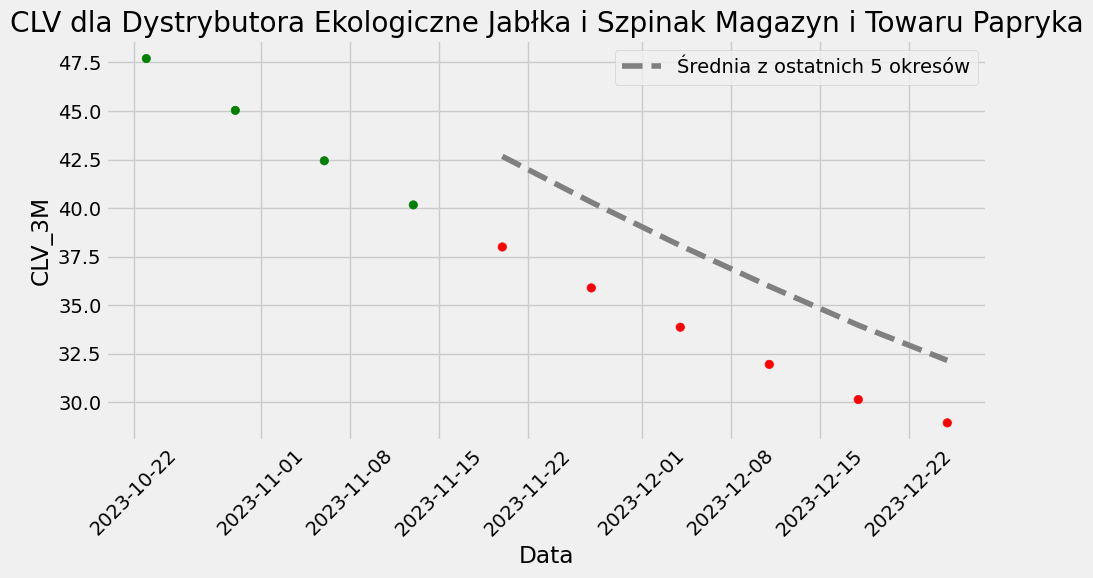

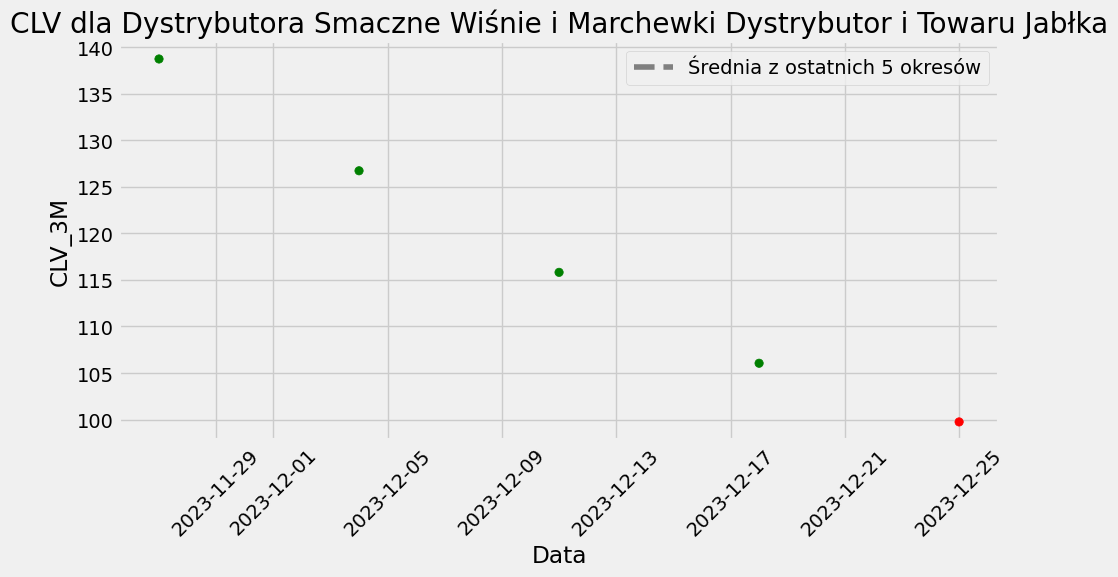

In [32]:
dystrybutorzy_towary = (clv_przedstawiciel['Dystrybutor']+'$'+clv_przedstawiciel['Towar']).unique()

for dystr_tow in dystrybutorzy_towary:
    dystrybutor, towar = dystr_tow.split('$')
    
    clv_przedstawiciel_w = clv_przedstawiciel.loc[(clv_przedstawiciel['Dystrybutor'] == dystrybutor) & (clv_przedstawiciel['Towar'] == towar)]
    
    clv_przedstawiciel_w['CLV_3M_Mean'] = clv_przedstawiciel_w['CLV_3M'].rolling(window=5).mean()
    
    clv_przedstawiciel_w['Color'] = clv_przedstawiciel_w.apply(lambda row: 'red' if row['CLV_3M'] < 0.9 * row['CLV_3M_Mean']
                                                     else 'orange' if row['CLV_3M'] < row['CLV_3M_Mean']
                                                     else 'green', axis=1)
    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(clv_przedstawiciel_w['Data'], clv_przedstawiciel_w['CLV_3M'], color=clv_przedstawiciel_w['Color'])
    plt.plot(clv_przedstawiciel_w['Data'], clv_przedstawiciel_w['CLV_3M_Mean'], linestyle='--', color='gray', label='Średnia z ostatnich 5 okresów')
    plt.title(f'CLV dla Dystrybutora {dystrybutor} i Towaru {towar}')
    plt.xlabel('Data')
    plt.ylabel('CLV_3M')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()